In [11]:
import pathlib
import numpy as np
import scipy as sp
import pandas as pd
from matplotlib import pyplot as plt

import pingouin as pg
from pingouin import mixed_anova, pairwise_tests
from statsmodels.formula.api import ols
from statsmodels.stats.multitest import multipletests

import SessionTools.two_photon as st2p
import NeuromodPlasticity as nmp

plt.rcParams['pdf.fonttype']=42

%load_ext autoreload
%autoreload 2 

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
common_fig_folder = pathlib.Path('/media/mplitt/SSD_storage/fig_scratch/GRAB')
common_fig_folder.mkdir(exist_ok=True, parents=True)

grabda_sess = nmp.grab_sensors.SessMaker(basedir = '/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABDA2m',
                                         figfolder=common_fig_folder / 'GRABDA2m',
                                         id_suffix='DA')

graboa_sess = nmp.grab_sensors.SessMaker(basedir = '/media/mplitt/SSD_storage/2P_scratch/R20A02_R56H10_split_GRABOA1',
                                         figfolder=common_fig_folder / 'GRABOA1',
                                        id_suffix='OA')



In [13]:
da_stats_df = nmp.grab_sensors.offset_stats(grabda_sess)
da_stats_df_unique = nmp.grab_sensors.offset_stats_unique(da_stats_df)
da_stats_df_plot = nmp.grab_sensors.offset_stats_plot(da_stats_df_unique)

oa_stats_df = nmp.grab_sensors.offset_stats(graboa_sess)
oa_stats_df_unique = nmp.grab_sensors.offset_stats_unique(oa_stats_df)
oa_stats_df_plot = nmp.grab_sensors.offset_stats_plot(oa_stats_df_unique)


In [14]:
da_stats_df_plot['fly_id'].shape

(10,)

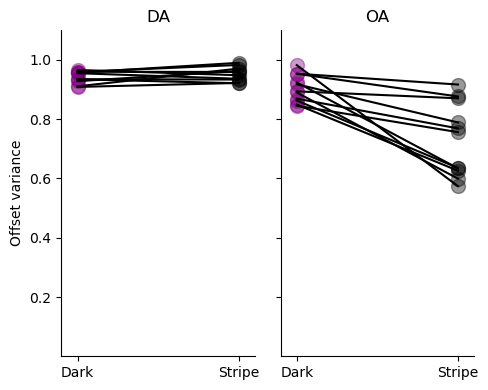

In [15]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[5,4])

ax[0].set_title('DA')
ax[0].plot([0,1], da_stats_df_plot[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[0].scatter(np.zeros((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_var_dark'], color='purple', alpha=.4, s=100)
ax[0].scatter(np.ones((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_var_closed_loop'], color='black', alpha=.4, s=100)

ax[1].set_title('OA')
ax[1].plot([0,1], oa_stats_df_plot[['offset_var_dark', 'offset_var_closed_loop']].T, color='black')
ax[1].scatter(np.zeros((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_var_dark'], color='purple', alpha=.4, s=100)
ax[1].scatter(np.ones((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_var_closed_loop'], color='black', alpha=.4, s=100)

for _ax in ax:
    _ax.set_ylim([0.0,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset variance')


fig.tight_layout()
fig.savefig(common_fig_folder / 'offset_variance_summary.pdf', format='pdf', bbox_inches='tight')

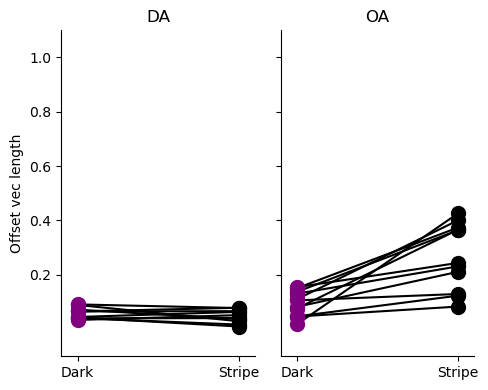

In [16]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[5,4])

ax[0].set_title('DA')
ax[0].plot([0,1], da_stats_df_plot[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[0].scatter(np.zeros((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[0].scatter(np.ones((da_stats_df_plot.shape[0],)), da_stats_df_plot['offset_mag_closed_loop'], color='black', alpha=1, s=100)

ax[1].set_title('OA')
ax[1].plot([0,1], oa_stats_df_plot[['offset_mag_dark', 'offset_mag_closed_loop']].T, color='black', zorder=-1)
ax[1].scatter(np.zeros((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_mag_dark'], color='purple', alpha=1, s=100)
ax[1].scatter(np.ones((oa_stats_df_plot.shape[0],)), oa_stats_df_plot['offset_mag_closed_loop'], color='black', alpha=1, s=100)

for _ax in ax:
    _ax.set_ylim([-.1,1.1])
    _ax.set_xlim([-.1,1.1])
    _ax.set_yticks([.2,.4,.6,.8,1.])

    _ax.set_xticks([0, 1], labels=['Dark', 'Stripe'])
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)
    
ax[0].set_ylabel('Offset vec length')


fig.tight_layout()
fig.savefig(common_fig_folder / 'offset_mag_summary.pdf', format='pdf', bbox_inches='tight')

In [17]:
oa_stats_df_unique.head()

fly_id  cl  dark  offset_var  offset_var_logit  offset_mean  \
0  10_12_2024_fly1_OA   1     0    0.599449          0.403169     2.941400   
1  10_12_2024_fly1_OA   0     1    0.890316          2.093973     3.937605   
2  10_12_2024_fly3_OA   1     0    0.917035          2.402730     4.973254   
3  10_12_2024_fly3_OA   0     1    0.953654          3.024166     1.164431   
4  06_01_2025_fly2_OA   1     0    0.756339          1.132710     5.018582   

   offset_mag  
0    0.400551  
1    0.109684  
2    0.082965  
3    0.046346  
4    0.243661

In [18]:
# mixed anova
da_stats_df_unique['group'] = 'DA'
oa_stats_df_unique['group'] = 'OA'

stats_df_unique = pd.concat([da_stats_df_unique,oa_stats_df_unique])
aov = mixed_anova(dv='offset_var_logit', between='group',
                  within='dark', subject='fly_id', data=stats_df_unique)
aov


Source         SS  DF1  DF2         MS          F     p-unc       np2  \
0        group  16.483054    1   19  16.483054  32.747536  0.000016  0.632833   
1         dark   2.728303    1   19   2.728303   7.751809  0.011823  0.289768   
2  Interaction   6.938477    1   19   6.938477  19.713996  0.000281  0.509221   

   eps  
0  NaN  
1  1.0  
2  NaN

In [19]:
oa_stats_df_unique['fly_id'].unique().shape

(11,)

<Axes: xlabel='Theoretical quantiles', ylabel='Ordered quantiles'>

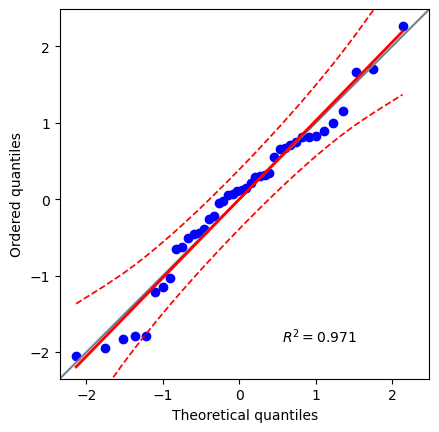

In [20]:
pg.qqplot(stats_df_unique['offset_var_logit'])

In [21]:
tt = pairwise_tests(dv='offset_var_logit', between='group',
                   subject='fly_id', within='dark', data=stats_df_unique,
                   padjust='holm', parametric=True, interaction=True, within_first=False)

tt

Contrast group   A   B Paired  Parametric         T        dof  \
0         group     -  DA  OA  False        True  5.767046  18.942261   
1          dark     -   0   1   True        True -2.001163  20.000000   
2  group * dark    DA   0   1   True        True  1.576996   9.000000   
3  group * dark    OA   0   1   True        True -4.461893  10.000000   

  alternative     p-unc    p-corr p-adjust      BF10    hedges  
0   two-sided  0.000015       NaN      NaN  1018.446  2.400346  
1   two-sided  0.059131       NaN      NaN     1.198 -0.502188  
2   two-sided  0.149251  0.149251     holm     0.795  0.572275  
3   two-sided  0.001213  0.002425     holm    34.439 -1.720270

In [22]:
sp.stats.ttest_ind(stats_df_unique['offset_var_logit'].loc[(stats_df_unique['dark']==0) & (stats_df_unique['group']=='DA')], 
                   stats_df_unique['offset_var_logit'].loc[(stats_df_unique['dark']==0) & (stats_df_unique['group']=='OA')])

TtestResult(statistic=6.577197340088531, pvalue=2.694184412986693e-06, df=19.0)

In [23]:
tt = pairwise_tests(dv='offset_var_logit', between='group',
                   subject='fly_id', within='dark', data=stats_df_unique,
                   padjust='holm', parametric=True, interaction=True, within_first=True)

tt

Contrast dark   A   B Paired  Parametric         T        dof  \
0          dark    -   0   1   True        True -2.001163  20.000000   
1         group    -  DA  OA  False        True  5.767046  18.942261   
2  dark * group    0  DA  OA  False        True  6.579714  18.837900   
3  dark * group    1  DA  OA  False        True  1.785036  15.525644   

  alternative     p-unc    p-corr p-adjust      BF10    hedges  
0   two-sided  0.059131       NaN      NaN     1.198 -0.502188  
1   two-sided  0.000015       NaN      NaN  1018.446  2.400346  
2   two-sided  0.000003  0.000006     holm   4538.95  2.758833  
3   two-sided  0.093803  0.093803     holm     1.156  0.728087

In [24]:
def group_rho_df(rho_stats):
    return rho_stats.groupby(['fly_id', 'cl']).apply(
    lambda x: pd.Series({
        'F_dig': np.nanmean(np.stack(x['F_dig']), axis=0),
        'rho_dig': np.nanmean(np.stack(x['rho_dig']), axis=0)
    })).reset_index()

In [25]:
dh_bins = np.linspace(0, 3.14, num=20)

da_stats = nmp.grab_sensors.rho_stats(grabda_sess, dh_bins=dh_bins)
da_stats.loc[da_stats['cl'] > 1, 'cl'] = 1
da_grouped = group_rho_df(da_stats)

oa_stats = nmp.grab_sensors.rho_stats(graboa_sess, dh_bins=dh_bins)
oa_stats.loc[oa_stats['cl'] > 1, 'cl'] = 1
oa_grouped = group_rho_df(oa_stats)




/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:171: RuntimeWarning: Mean of empty slice.
  rho_dig = np.array([ts.rho[dh_dig == i].mean() for i in range(len(dh_bins))])
/home/mplitt/mambaforge/envs/NeuroModPlasticity/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:172: RuntimeWarning: Mean of empty slice.
  F_dig = np.array([ts.outer_ring[dh_dig == i].mean() for i in range(len(dh_bins))])
/tmp/ipykernel_2257381/617967456.py:4: RuntimeWarning: Mean of empty slice
  'F_dig': np.nanmean(np.stack(x['F_dig']), axis=0),
/tmp/ipykernel_2257381/617967456.py:5: RuntimeWarning: Mean of empty slice
  'rho_dig': np.nanmean(np.stack(x['rho_dig']), axis=0)


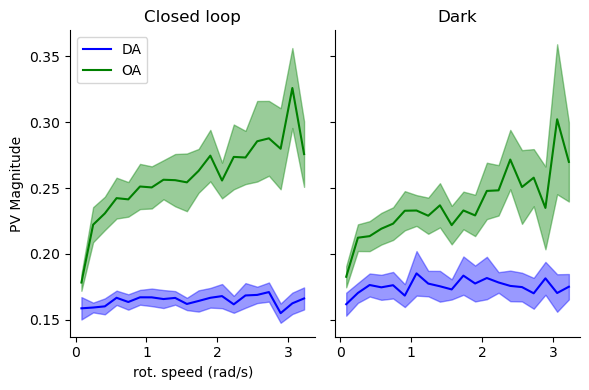

In [26]:
dh_bin_centers = dh_bins+np.diff(dh_bins)[0]/2

fig,ax = plt.subplots(1,2,sharey=True, figsize=[6,4])

rho_dig = np.stack(da_grouped.loc[da_grouped['cl']==1,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='blue', label='DA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

rho_dig = np.stack(da_grouped.loc[da_grouped['cl']==0,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='blue')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

rho_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==1,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', label='OA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4) 

ax[0].legend()

rho_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==0,'rho_dig'])
mu, sem = np.nanmean(rho_dig, axis=0), sp.stats.sem(rho_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4)

for _ax in ax:
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

ax[0].set_title('Closed loop')
ax[1].set_title('Dark')
ax[0].set_ylabel('PV Magnitude')
ax[0].set_xlabel('rot. speed (rad/s)')

fig.tight_layout()
fig.savefig(common_fig_folder / 'PV_magnitude_summary.pdf', format='pdf', bbox_inches='tight')

In [27]:
da_reg_stats = nmp.grab_sensors.reformat_rho_stats_for_reg(da_grouped, dh_bins)
da_reg_stats['group'] = 'DA'
oa_reg_stats = nmp.grab_sensors.reformat_rho_stats_for_reg(oa_grouped, dh_bins)
oa_reg_stats['group'] = 'OA'

reg_stats = pd.concat([da_reg_stats, oa_reg_stats])




/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:203: RuntimeWarning: invalid value encountered in log
  reg_df['log_F'].append(np.log(F))
/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:203: RuntimeWarning: invalid value encountered in log
  reg_df['log_F'].append(np.log(F))


In [28]:
reg_stats.head()

fly_id  cl       rho         F     log_F   log_rho        dh  \
0  02_01_2025_fly1_DA   0  0.148862 -0.339771       NaN -1.904733  0.000000   
1  02_01_2025_fly1_DA   0  0.180543  0.139519 -1.969553 -1.711785  0.165263   
2  02_01_2025_fly1_DA   0  0.169647  0.373610 -0.984542 -1.774036  0.330526   
3  02_01_2025_fly1_DA   0  0.149999  0.466953 -0.761526 -1.897127  0.495789   
4  02_01_2025_fly1_DA   0  0.174309  0.489493 -0.714385 -1.746925  0.661053   

  group  
0    DA  
1    DA  
2    DA  
3    DA  
4    DA

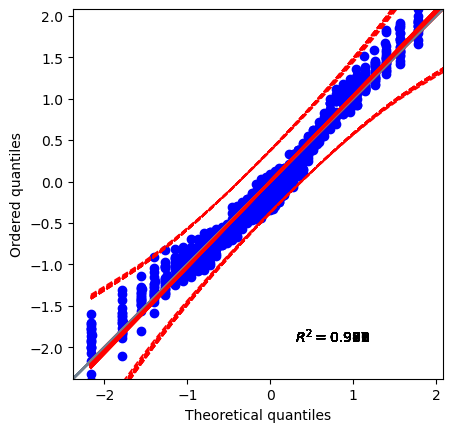

In [29]:
for dh in reg_stats['dh'].unique():
    pg.qqplot(reg_stats['log_rho'].loc[reg_stats['dh']==dh])

In [30]:
aov = mixed_anova(dv='log_rho', between='group',
                  within='dh', subject='fly_id', data=reg_stats.loc[reg_stats['cl']==1])
aov

Source         SS  DF1  DF2         MS          F         p-unc  \
0        group  20.276665    1   21  20.276665  32.288294  1.220530e-05   
1           dh   1.431153   19  399   0.075324   5.884418  4.151838e-13   
2  Interaction   1.125205   19  399   0.059221   4.626463  1.201282e-09   

        np2       eps  
0  0.605917       NaN  
1  0.218878  0.272406  
2  0.180535       NaN

In [31]:
model = ols('log_rho ~ dh*C(group)', reg_stats.loc[reg_stats['cl']==1])

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                log_rho   R-squared:                       0.548
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     191.6
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           2.06e-81
Time:                        11:36:00   Log-Likelihood:                 83.340
No. Observations:                 479   AIC:                            -158.7
Df Residuals:                     475   BIC:                            -142.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.8219      0.02

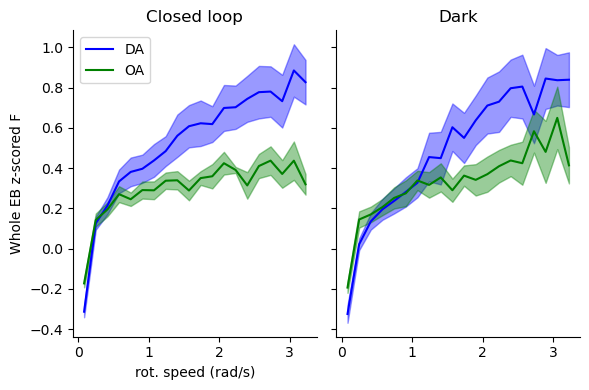

In [32]:
fig,ax = plt.subplots(1,2,sharey=True, figsize=[6,4])

F_dig = np.stack(da_grouped.loc[da_grouped['cl']==1,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='blue', label='DA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

F_dig = np.stack(da_grouped.loc[da_grouped['cl']==0,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='blue')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='blue', alpha=.4)

F_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==1,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[0].plot(dh_bin_centers, mu, color='green', label='OA')
ax[0].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4) 

ax[0].legend()

F_dig = np.stack(oa_grouped.loc[oa_grouped['cl']==0,'F_dig'])
mu, sem = np.nanmean(F_dig, axis=0), sp.stats.sem(F_dig, axis=0, nan_policy='omit')
ax[1].plot(dh_bin_centers, mu, color='green')
ax[1].fill_between(dh_bin_centers, mu-sem, mu+sem, color='green', alpha=.4)

for _ax in ax:
    _ax.spines['top'].set_visible(False)
    _ax.spines['right'].set_visible(False)

ax[0].set_title('Closed loop')
ax[1].set_title('Dark')
ax[0].set_ylabel('Whole EB z-scored F')
ax[0].set_xlabel('rot. speed (rad/s)')

fig.tight_layout()
fig.savefig(common_fig_folder / 'F_summary.pdf', format='pdf', bbox_inches='tight')

In [33]:
model = ols('log_F ~ dh*C(group)', reg_stats.loc[reg_stats['cl']==1])

result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  log_F   R-squared:                       0.266
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     53.71
Date:                Fri, 07 Nov 2025   Prob (F-statistic):           1.21e-29
Time:                        11:36:01   Log-Likelihood:                -479.23
No. Observations:                 449   AIC:                             966.5
Df Residuals:                     445   BIC:                             982.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -1.5404      0.10

In [34]:
# 3
row = graboa_sess.sess_df.iloc[3]
fly_id = row['fly_id']
sess = nmp.session.GetTS(graboa_sess.load_row(row))


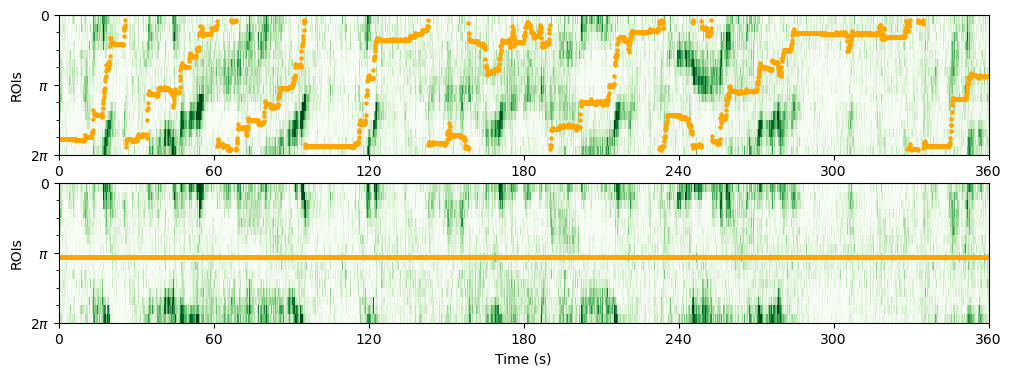

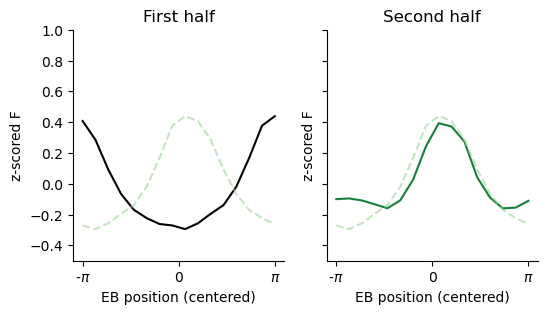

In [35]:
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

def get_time_ticks_inds(time, plot_times):
        inds = []
        for t in plot_times:
            inds.append(np.argmin(np.abs(time-t)))
        return inds

fig, ax = plt.subplots(2,1, figsize=[12,4])

x = np.arange(sess.dff.shape[1])
heading_ = (sess.heading + np.pi) / (2 * np.pi) * 15
time = sess.time - sess.time[0]
ax[0].imshow(sess.dff, cmap='Greens', aspect='auto', vmin=-.5, vmax=3, interpolation='none')
ax[1].imshow(sess.dff_h_aligned, cmap = 'Greens', aspect='auto', vmin=-.5, vmax=3, interpolation='none')
ax[0].scatter(x, heading_, color='orange', s=5)
ax[1].scatter(x, 8*np.ones_like(x), color='orange', s=5)

plot_times = np.arange(0, 361, 60)
for a in ax:
    a.set_ylabel('ROIs')
    a.set_yticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
    a.yaxis.set_minor_locator(AutoMinorLocator())
        
    
    a.set_xticks(get_time_ticks_inds(time, plot_times), labels=plot_times)
    a.set_xlabel('Time (s)')

fig.savefig(common_fig_folder / f'{fly_id}_aligned_heatmap.pdf')

fig, ax = plt.subplots(1,2, figsize=[6,3], sharey=True)
halfway = int(sess.dff_h_aligned.shape[1]/2)
mu = sess.dff_h_aligned[:, :halfway].mean(axis=-1)
shift = np.argmax(mu)
ax[0].plot(mu, color='k')
ax[0].plot(np.roll(mu, -shift-8), color=plt.cm.Greens(0.4), linestyle='--', alpha=.6)

ax[1].plot(np.roll(sess.dff_h_aligned[:, halfway:].mean(axis=-1),-shift-8), color=plt.cm.Greens(0.8))
ax[1].plot(np.roll(mu, -shift-8), color=plt.cm.Greens(0.4), linestyle='--', alpha=.6)

for a in ax:
    a.set_ylim([-.5,1])
    a.set_xticks([0,7.5,15], labels=[r'-$\pi$', '0',  r'$\pi$'])
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylabel('z-scored F')
    a.set_xlabel('EB position (centered)')

ax[0].set_title('First half')
ax[1].set_title('Second half')

fig.savefig(common_fig_folder / f'{fly_id}_aligned_mean.pdf')



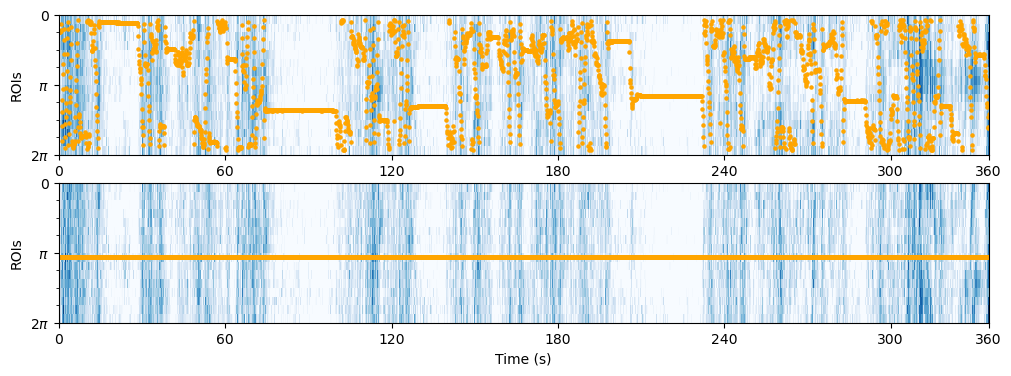

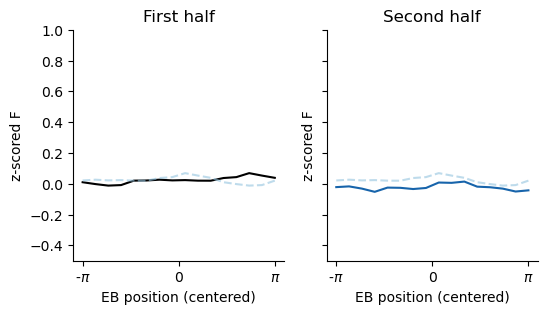

In [36]:
row = grabda_sess.sess_df.iloc[14]
fly_id = row['fly_id']
sess = nmp.session.GetTS(grabda_sess.load_row(row))

fig, ax = plt.subplots(2,1, figsize=[12,4])

x = np.arange(sess.dff.shape[1])
heading_ = (sess.heading + np.pi) / (2 * np.pi) * 15
time = sess.time - sess.time[0]
ax[0].imshow(sess.dff, cmap='Blues', aspect='auto', vmin=-.5, vmax=3, interpolation='none')
ax[1].imshow(sess.dff_h_aligned, cmap = 'Blues', aspect='auto', vmin=-.5, vmax=3, interpolation='none')
ax[0].scatter(x, heading_, color='orange', s=5)
ax[1].scatter(x, 8*np.ones_like(x), color='orange', s=5)

plot_times = np.arange(0, 361, 60)
for a in ax:
    a.set_ylabel('ROIs')
    a.set_yticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
    a.yaxis.set_minor_locator(AutoMinorLocator())
        
    
    a.set_xticks(get_time_ticks_inds(time, plot_times), labels=plot_times)
    a.set_xlabel('Time (s)')

fig.savefig(common_fig_folder / f'{fly_id}_aligned_heatmap.pdf')

fig, ax = plt.subplots(1,2, figsize=[6,3], sharey=True)
halfway = int(sess.dff_h_aligned.shape[1]/2)
mu = sess.dff_h_aligned[:, :halfway].mean(axis=-1)
shift = np.argmax(mu)
ax[0].plot(mu, color='k')
ax[0].plot(np.roll(mu, -shift-8), color=plt.cm.Blues(0.4), linestyle='--', alpha=.6)

ax[1].plot(np.roll(sess.dff_h_aligned[:, halfway:].mean(axis=-1),-shift-8), color=plt.cm.Blues(0.8))
ax[1].plot(np.roll(mu, -shift-8), color=plt.cm.Blues(0.4), linestyle='--', alpha=.6)

for a in ax:
    a.set_ylim([-.5,1])
    a.set_xticks([0,7.5,15], labels=[r'-$\pi$', '0',  r'$\pi$'])
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylabel('z-scored F')
    a.set_xlabel('EB position (centered)')

ax[0].set_title('First half')
ax[1].set_title('Second half')

fig.savefig(common_fig_folder / f'{fly_id}_aligned_mean.pdf')

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:371: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})


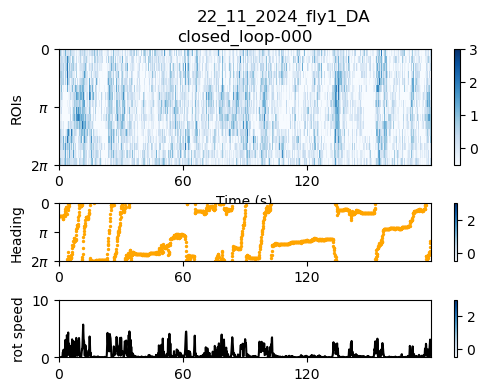

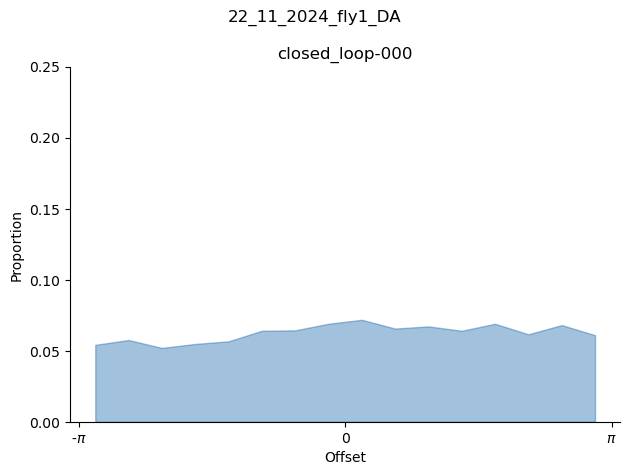

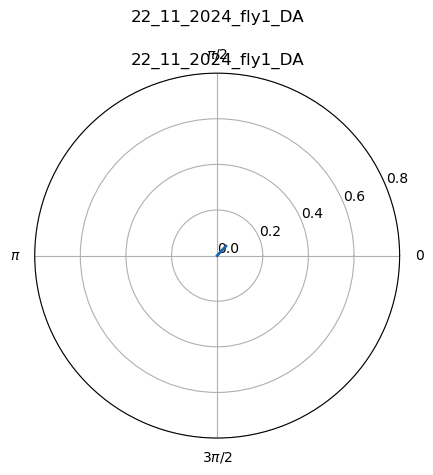

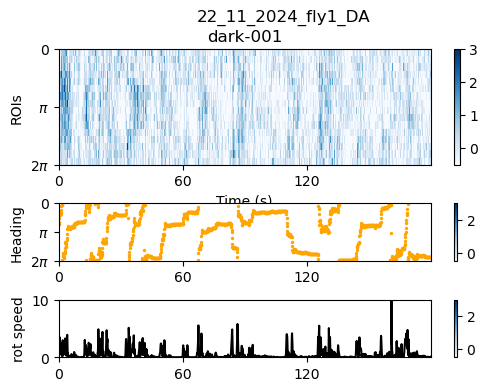

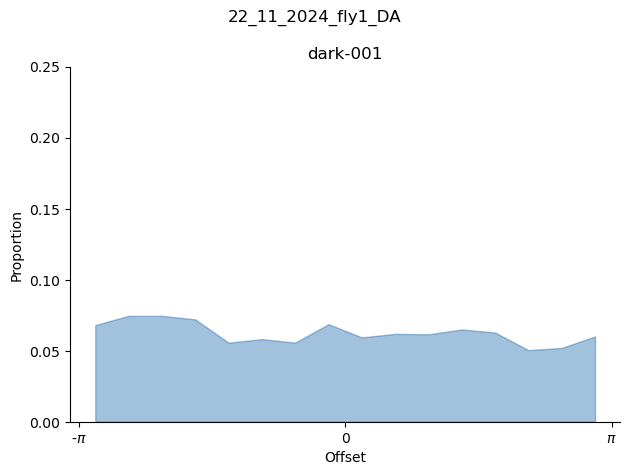

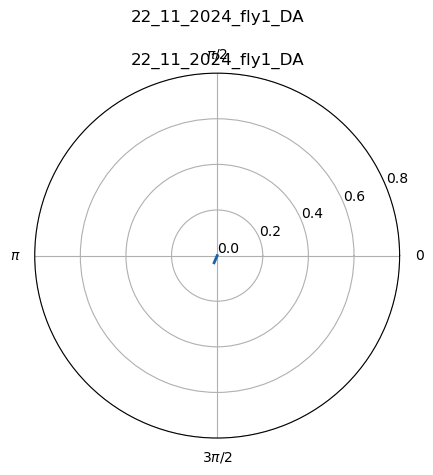

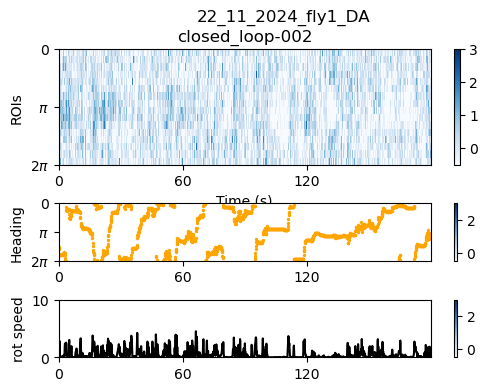

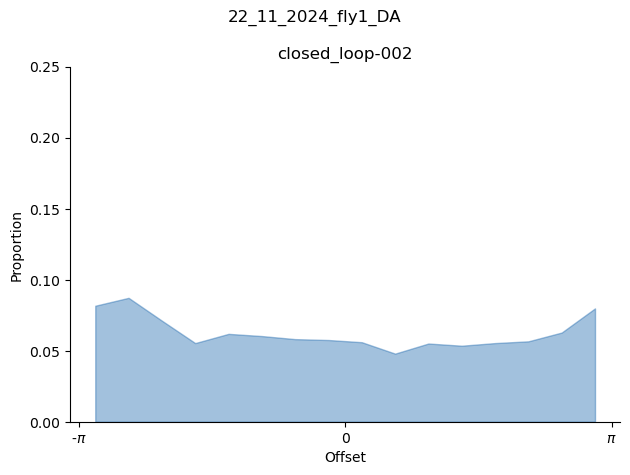

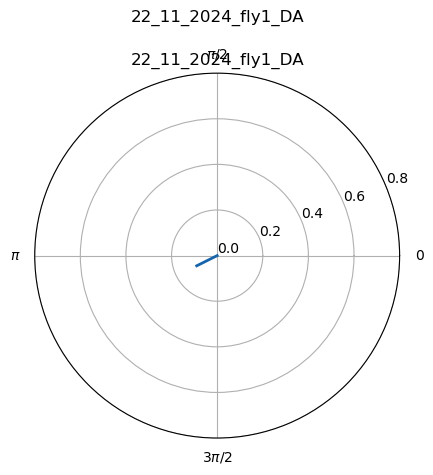

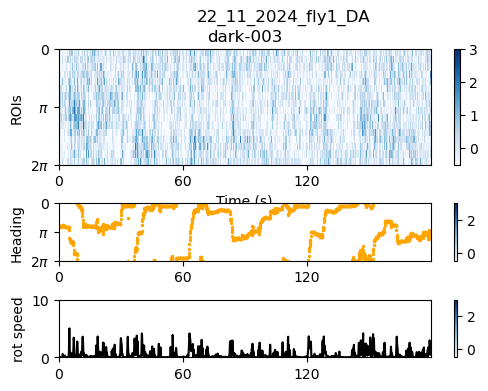

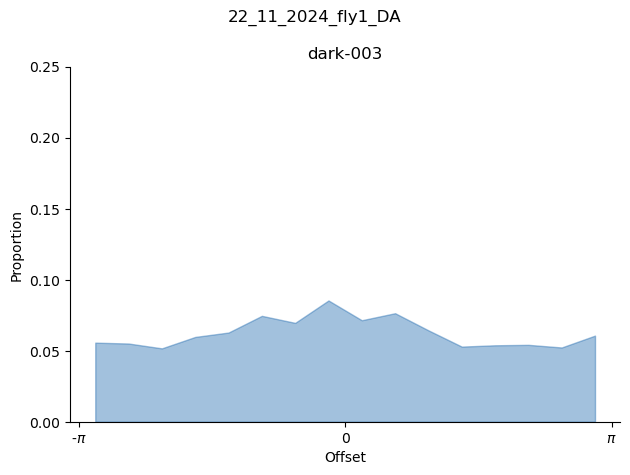

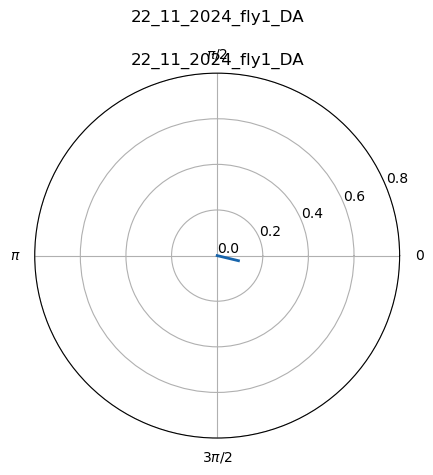

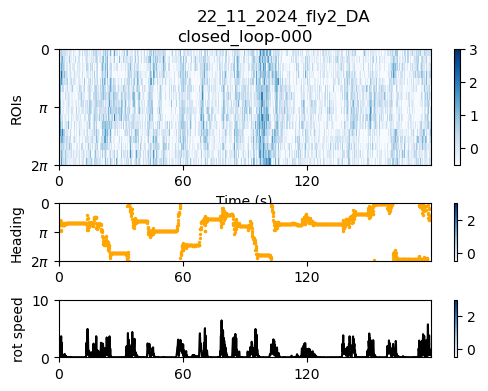

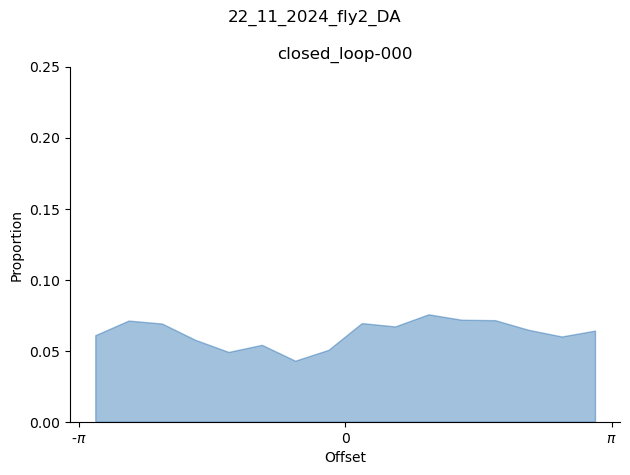

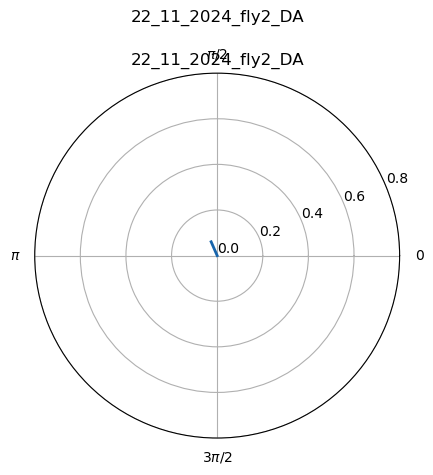

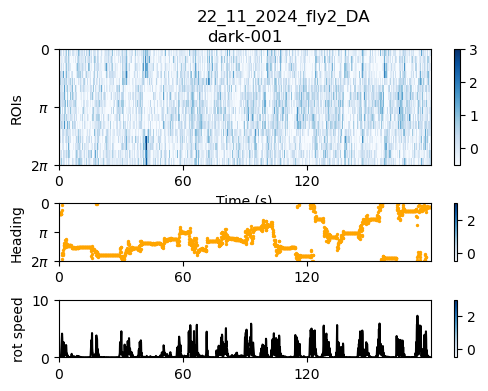

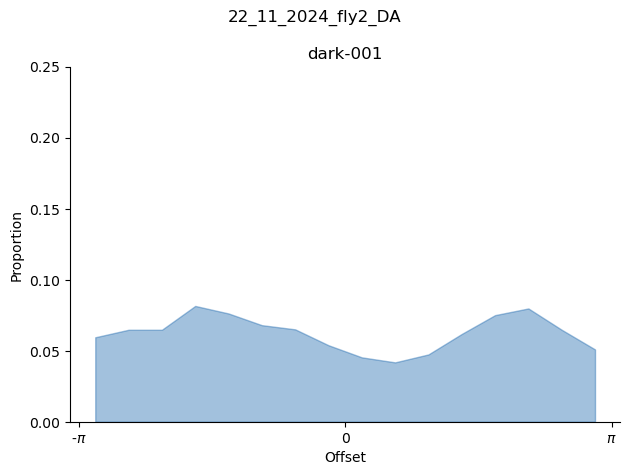

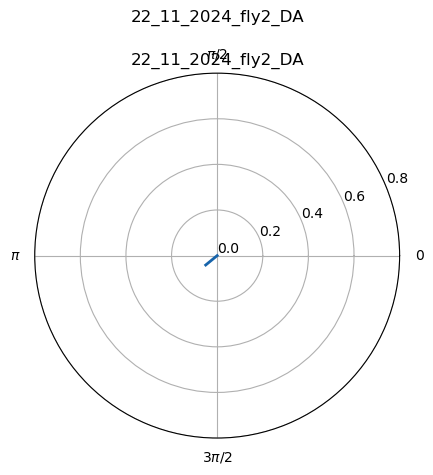

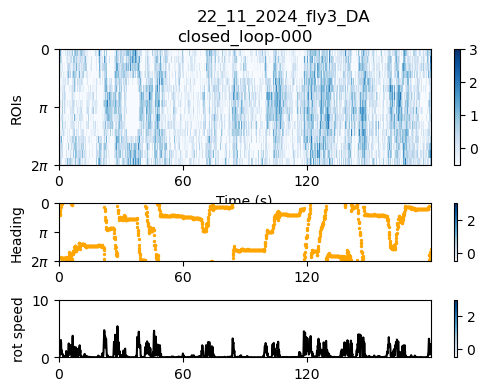

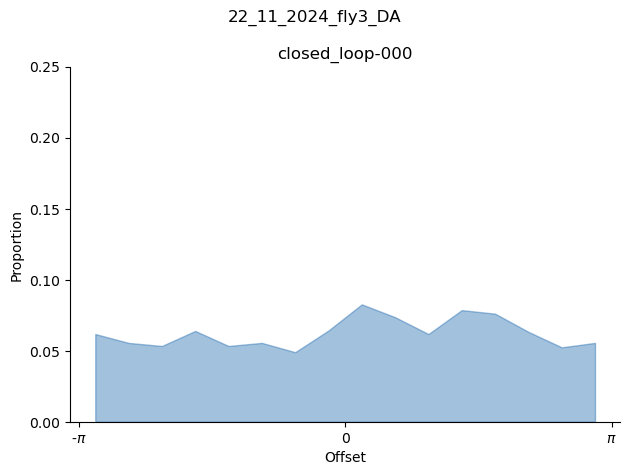

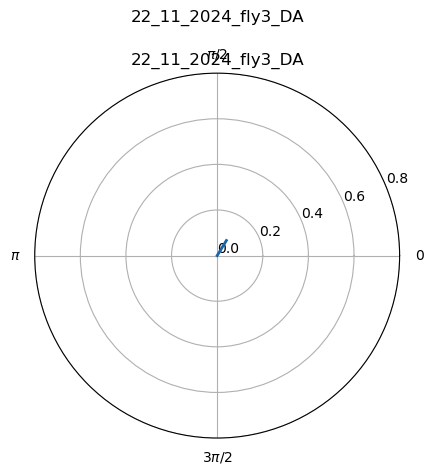

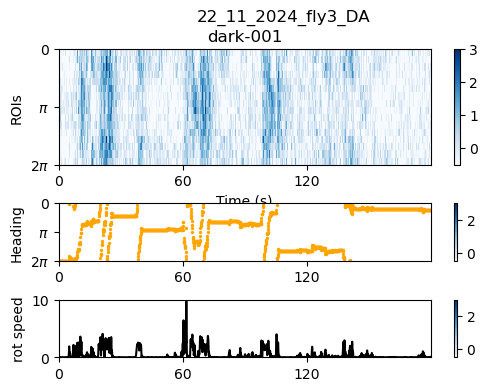

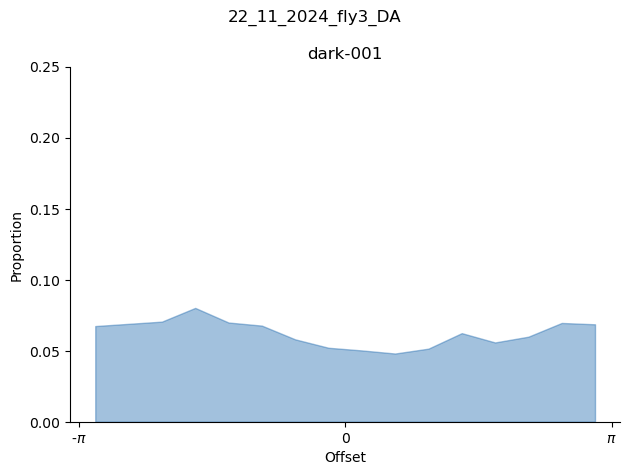

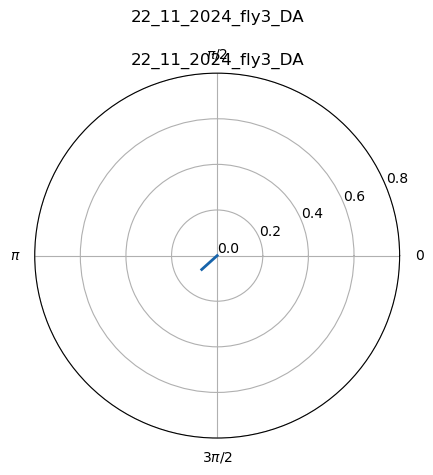

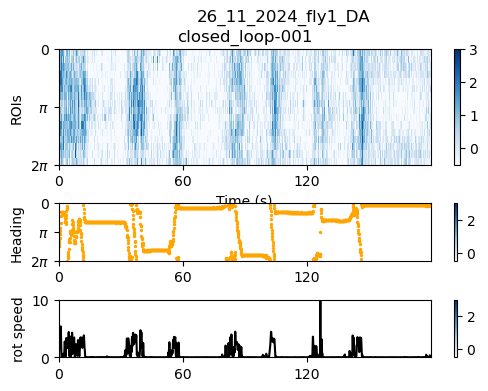

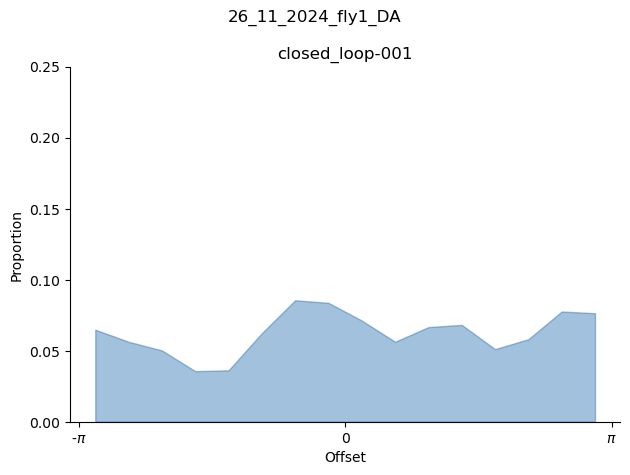

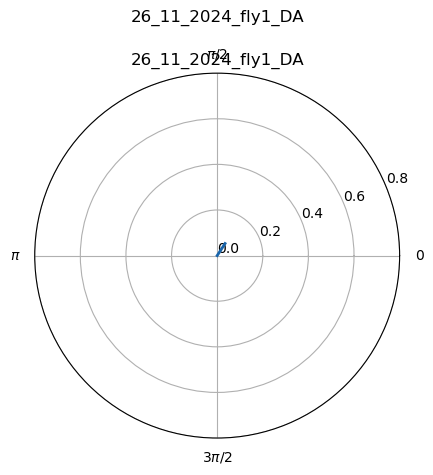

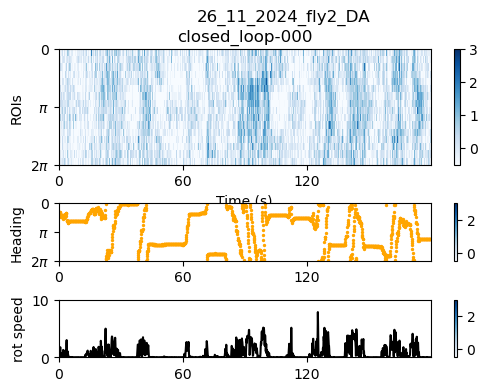

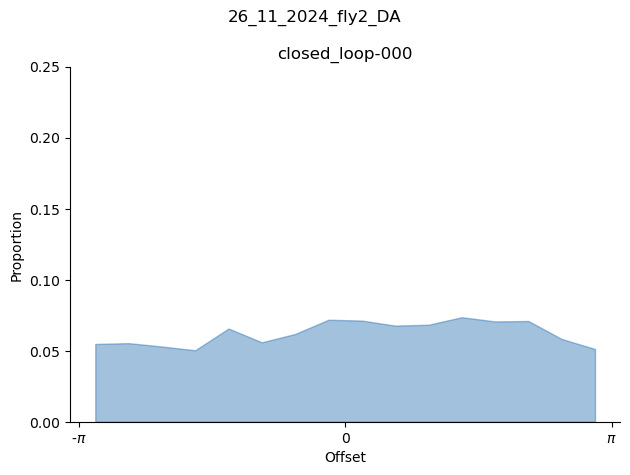

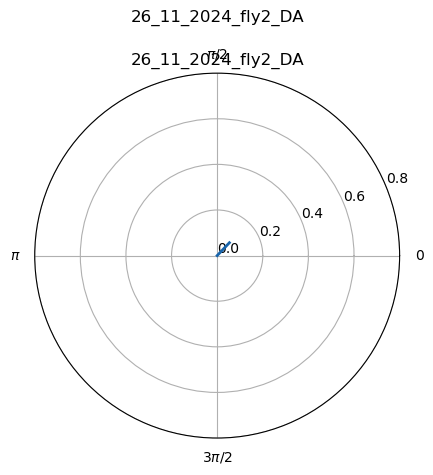

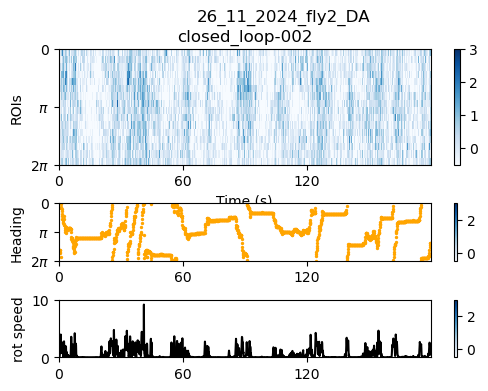

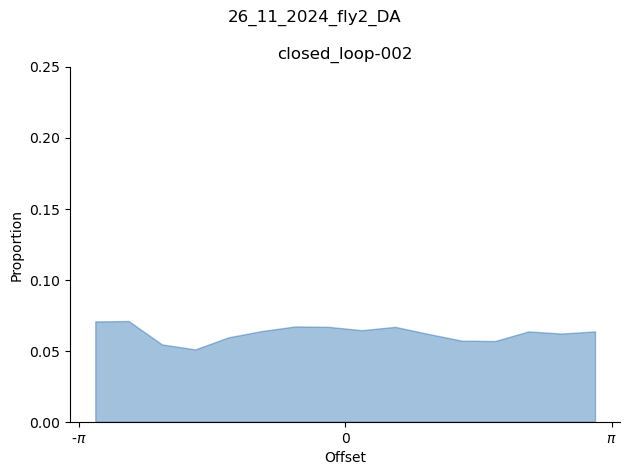

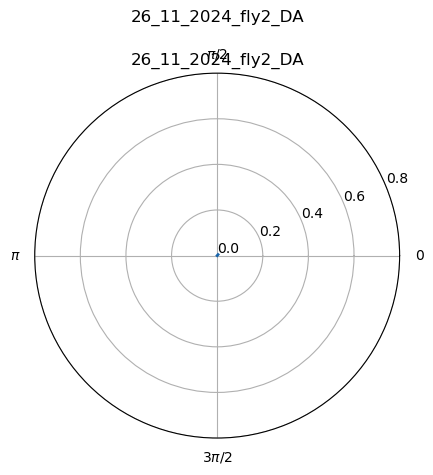

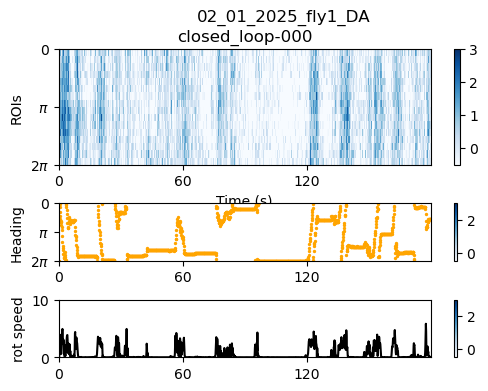

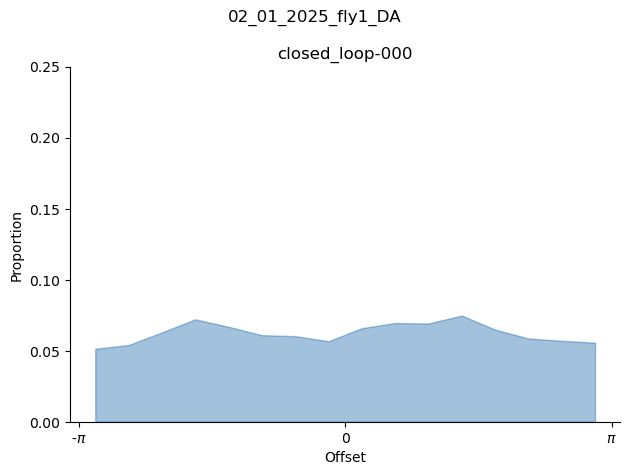

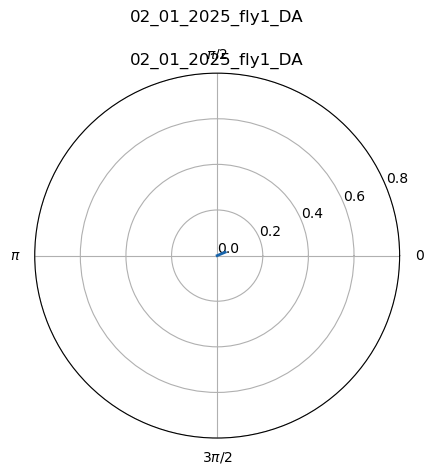

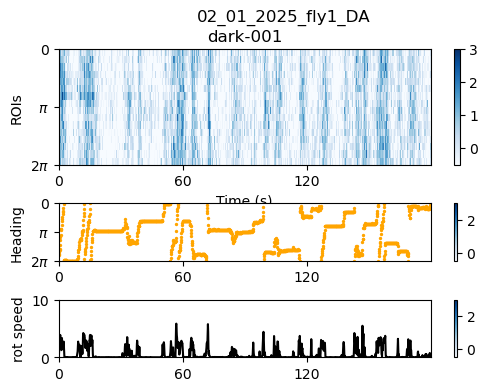

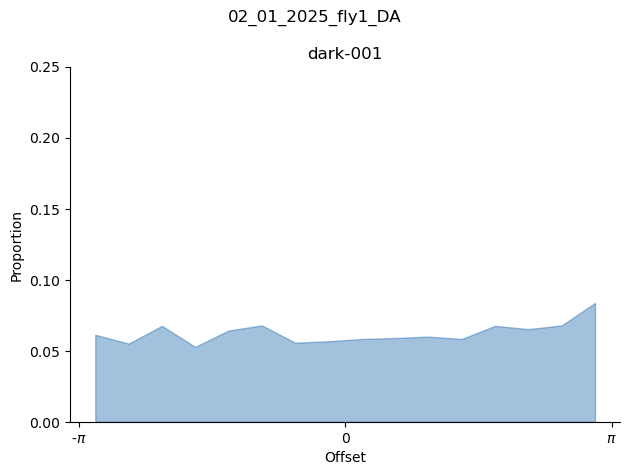

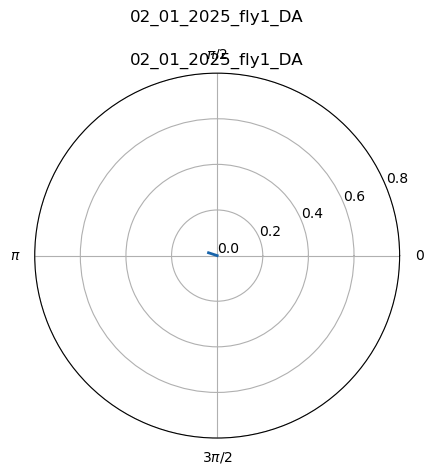

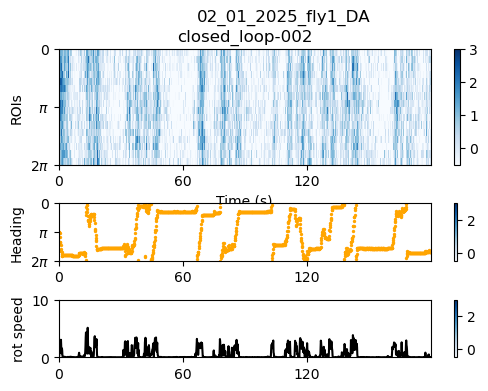

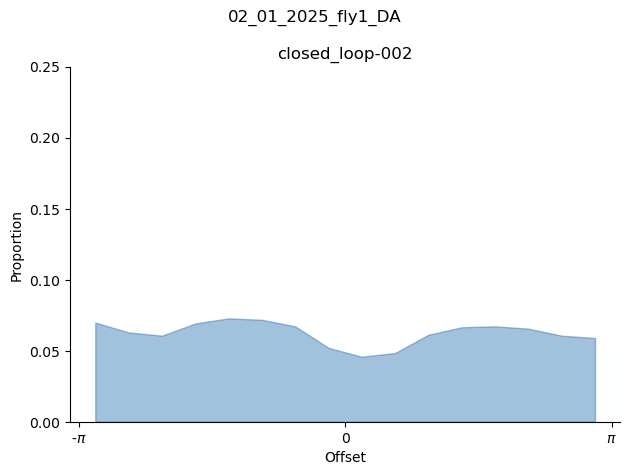

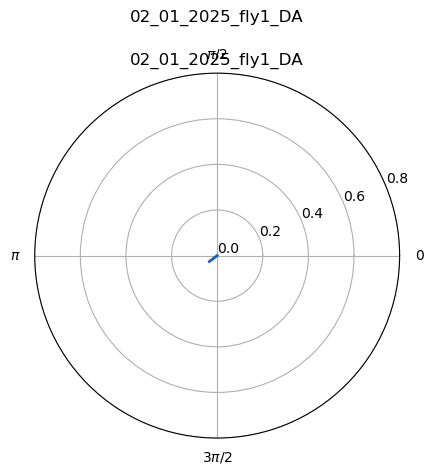

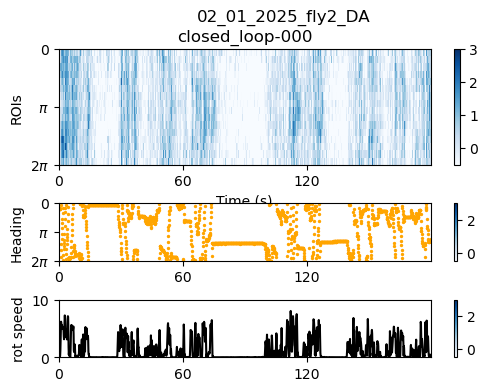

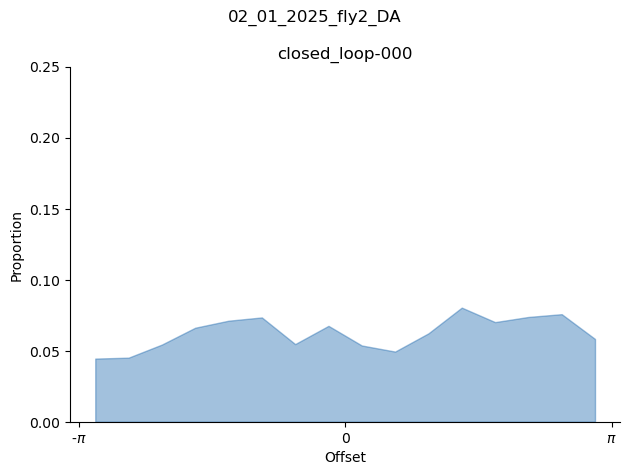

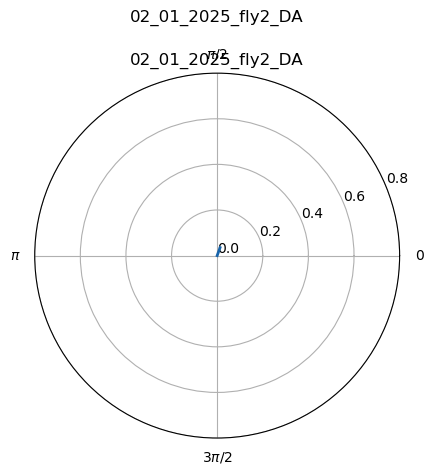

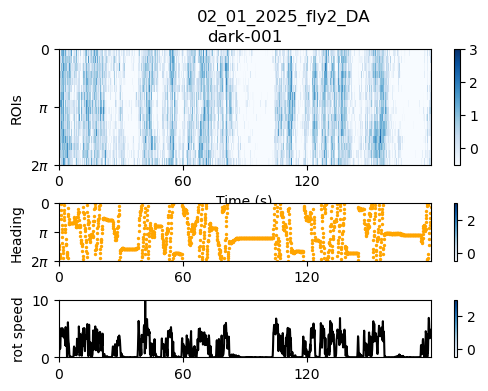

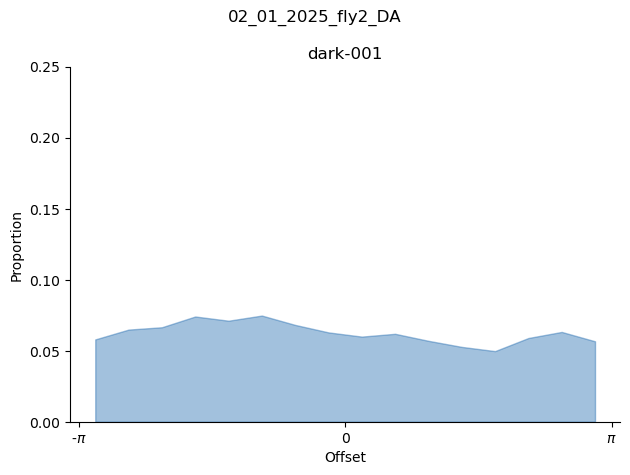

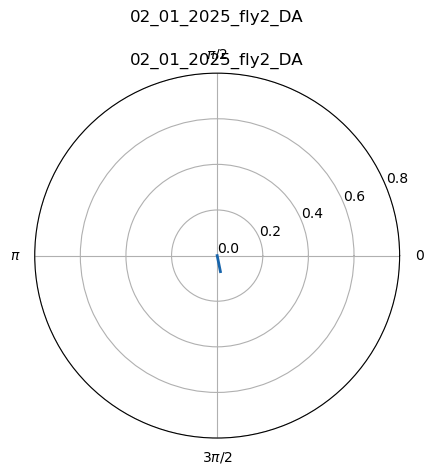

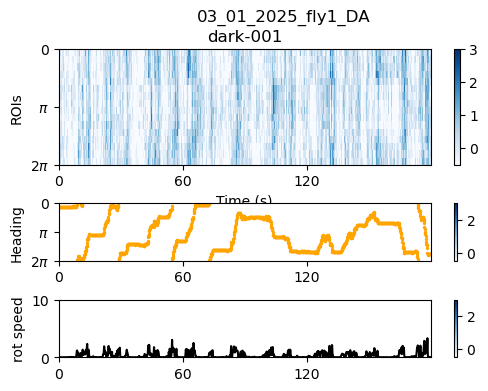

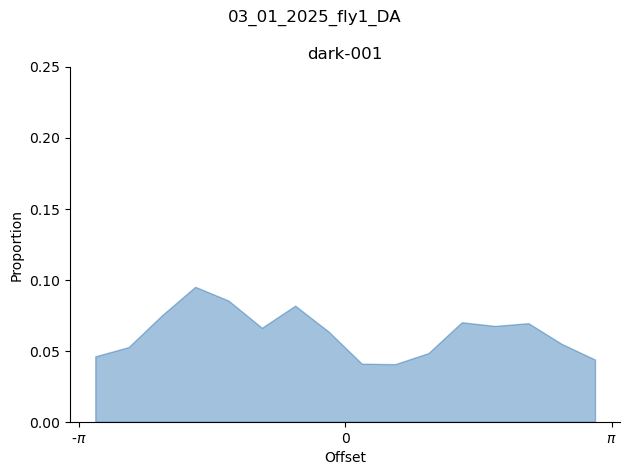

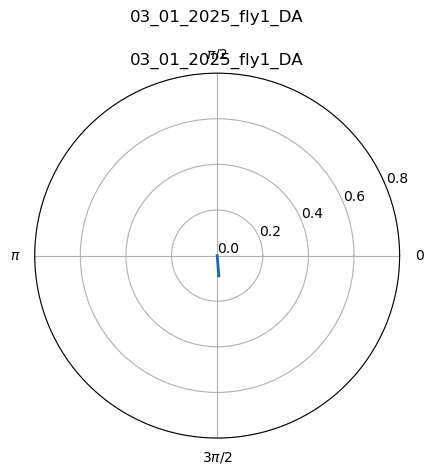

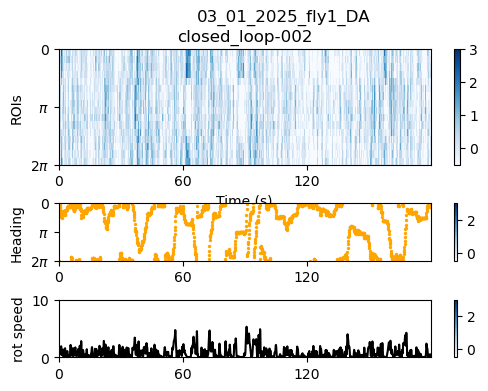

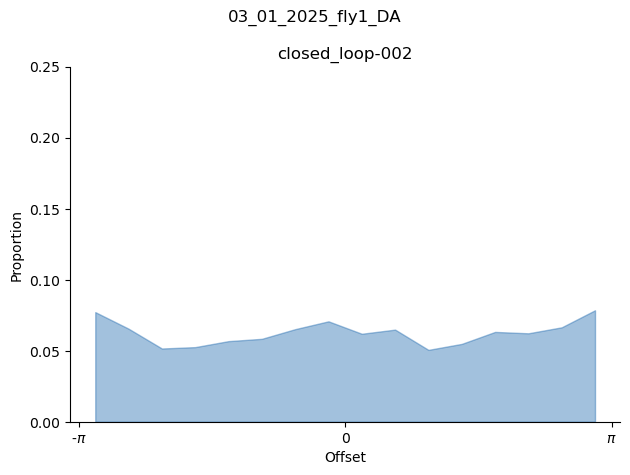

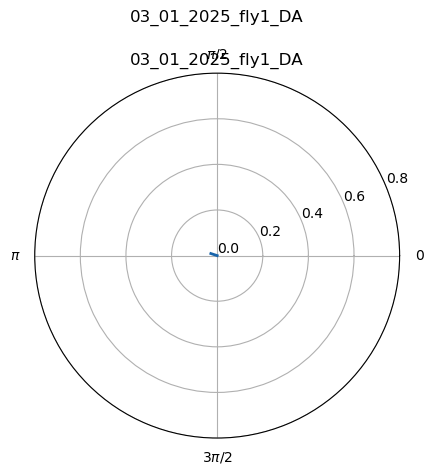

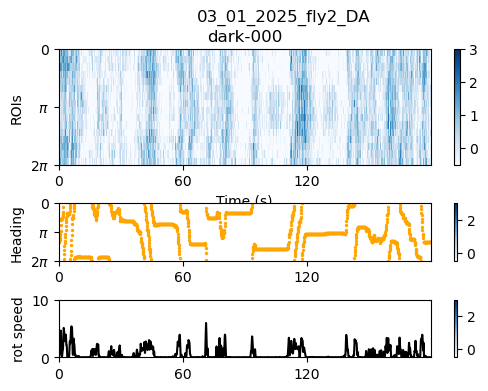

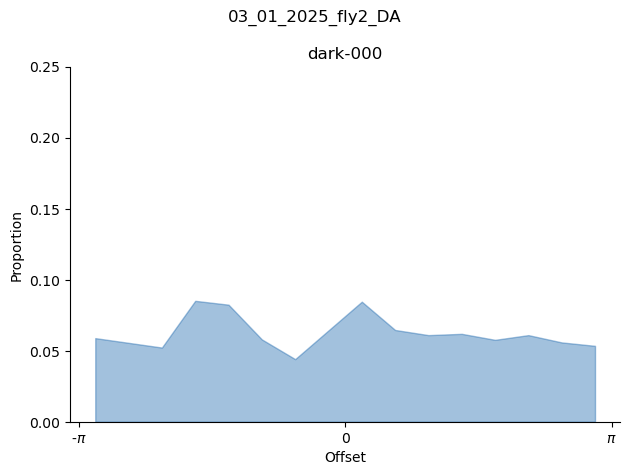

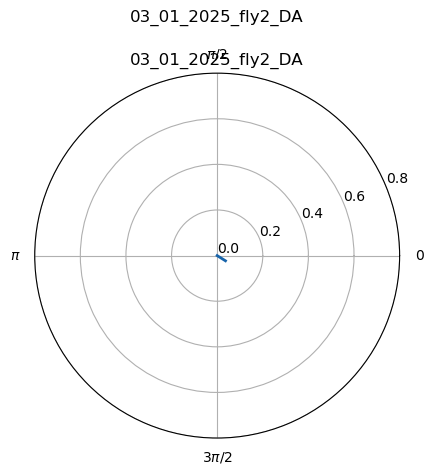

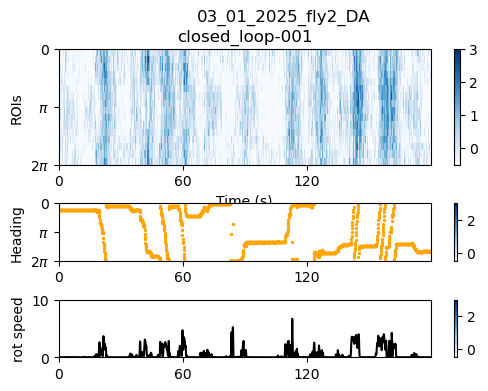

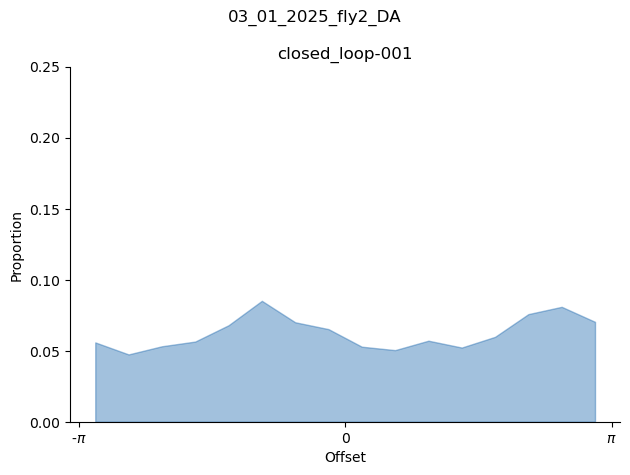

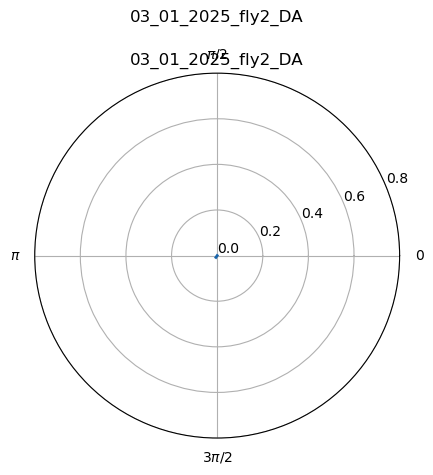

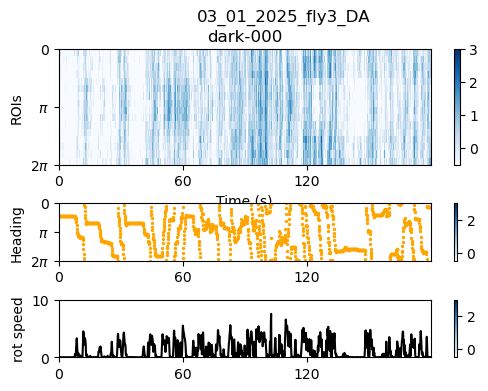

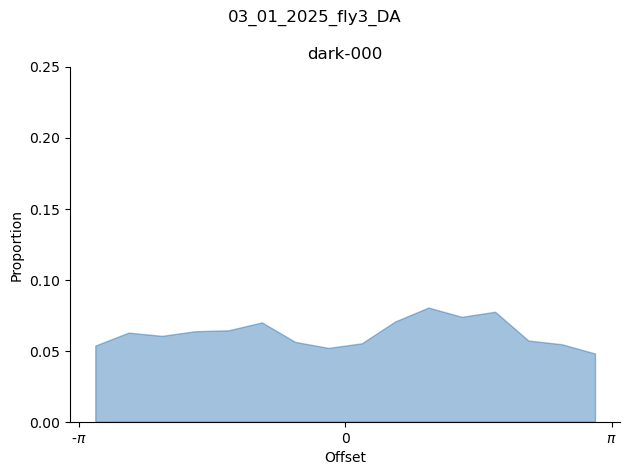

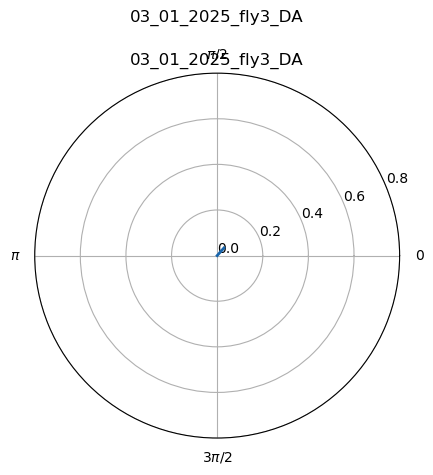

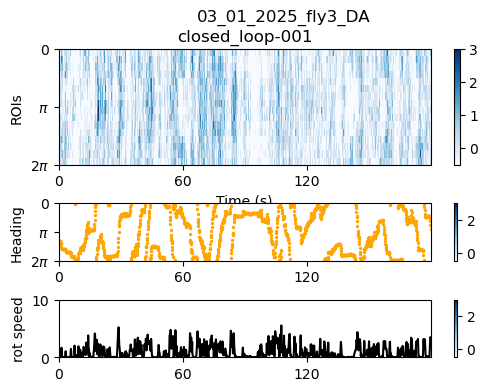

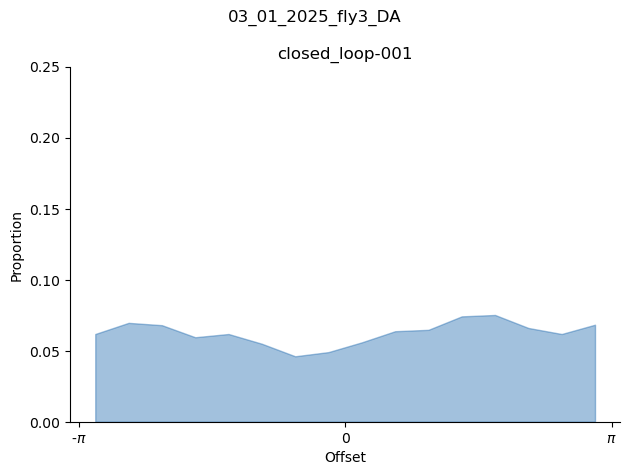

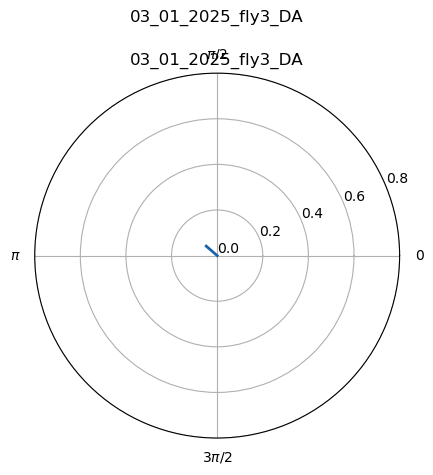

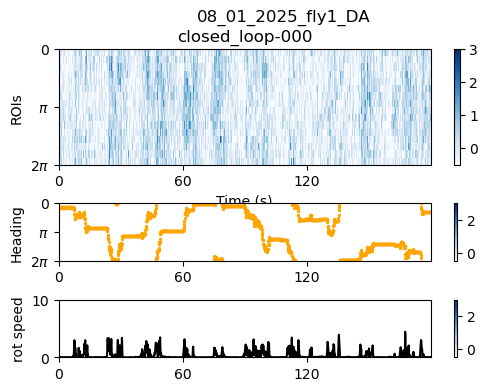

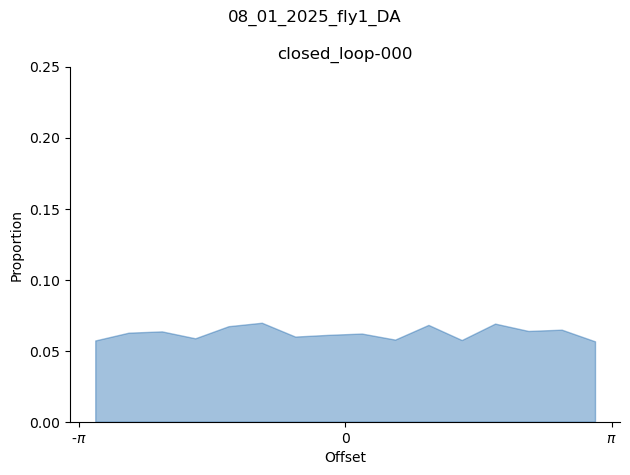

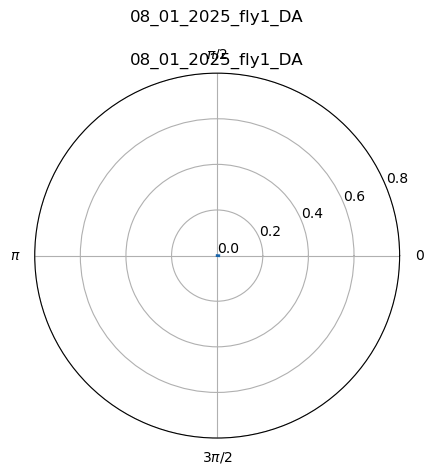

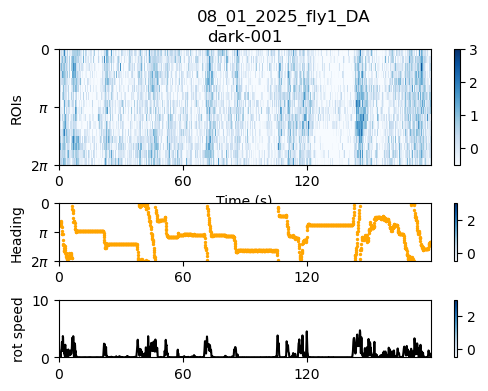

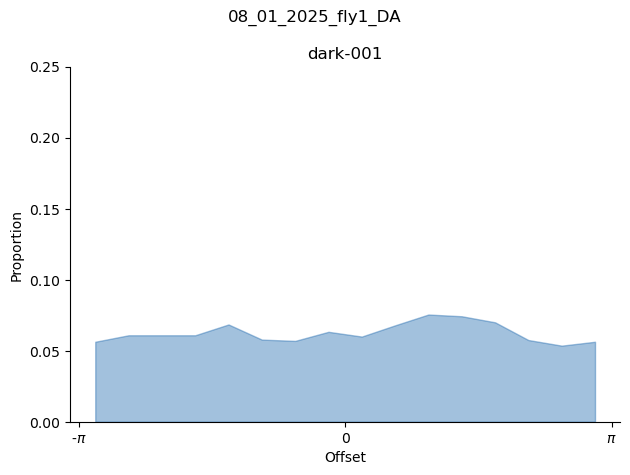

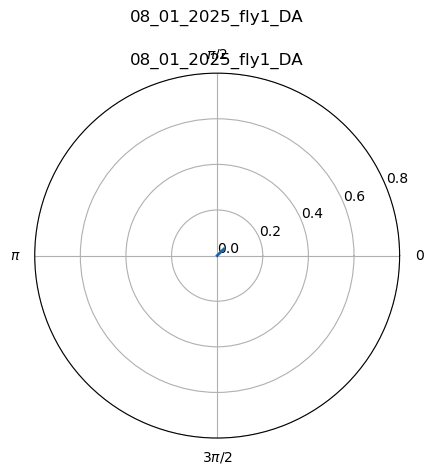

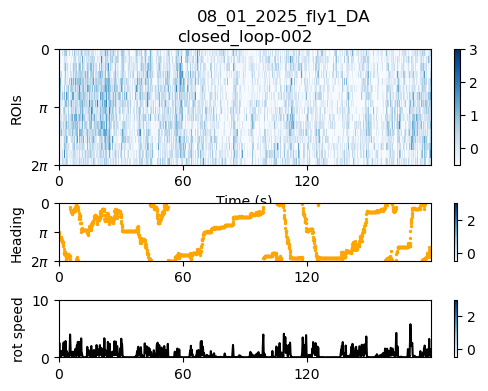

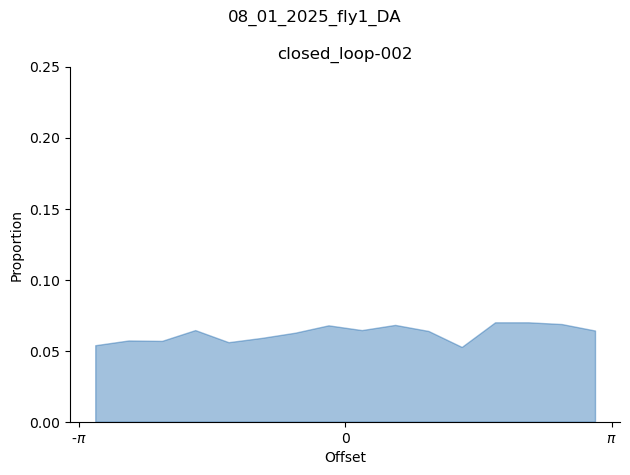

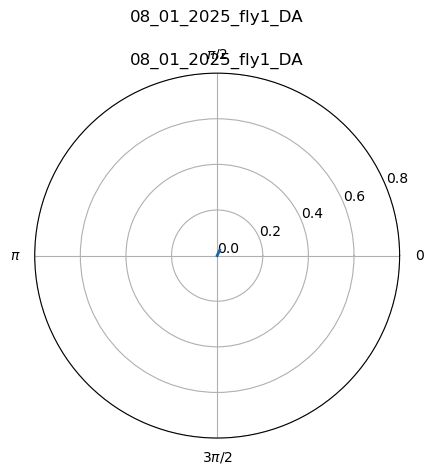

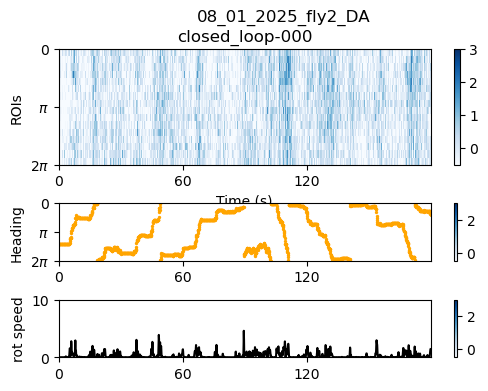

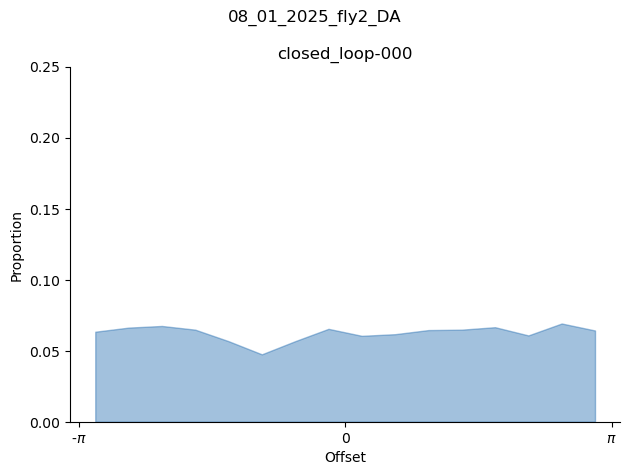

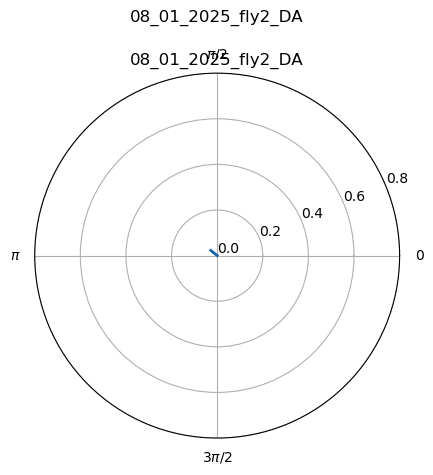

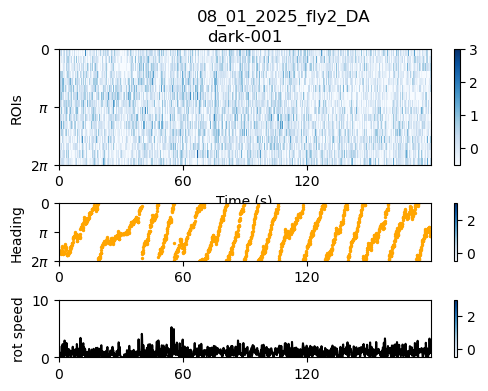

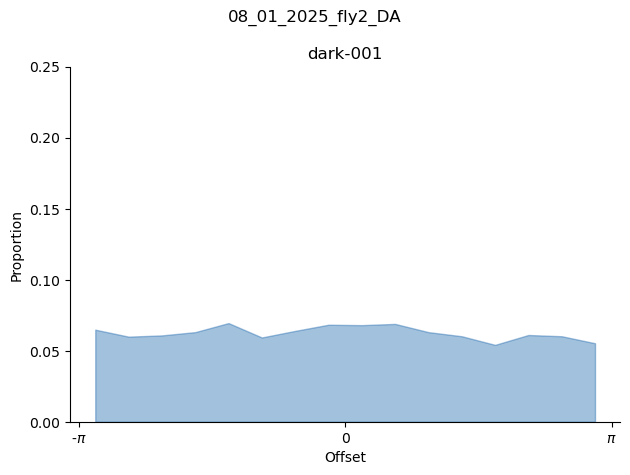

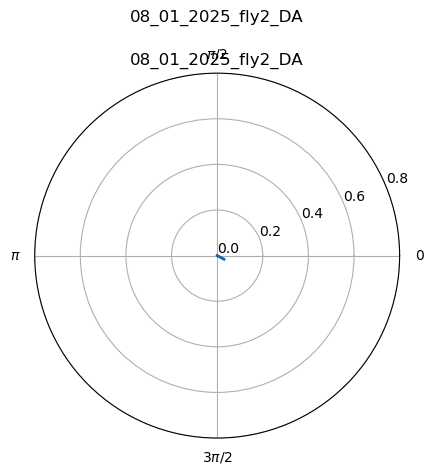

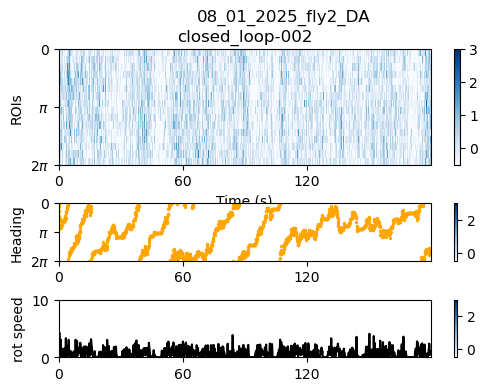

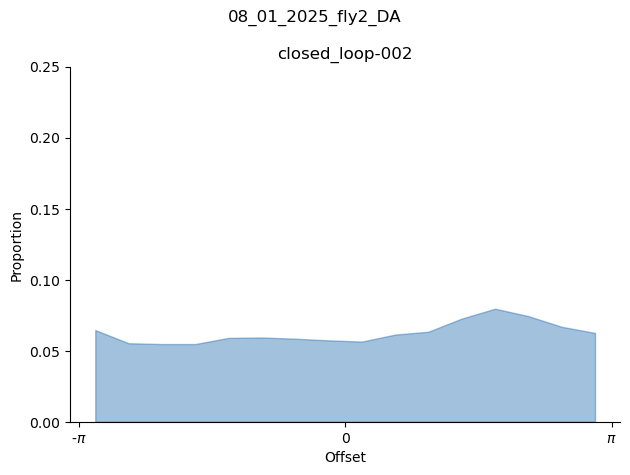

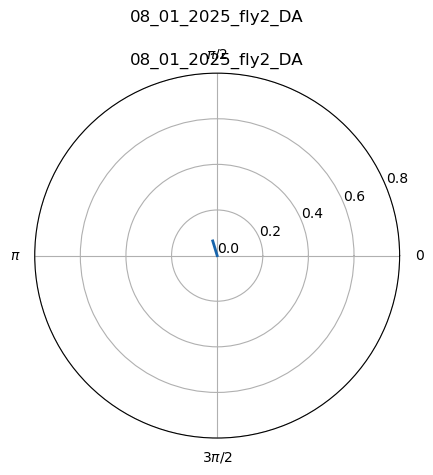

In [37]:
session_folder = grabda_sess.fig_folder / "sessions"
# plt.ioff()
for _, row in grabda_sess.sess_df.iloc[:].iterrows():
        
    ts_dict = {'fly': row['fly_id'],
                row['session']: nmp.session.GetTS(grabda_sess.load_row(row))
    }
    
    fig_heatmaps = nmp.grab_sensors.plot_sess_heatmaps(ts_dict, cmap='Blues', twindow=(0,180),vmin=-.5,vmax=3)
    (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.grab_sensors.plot_sess_histograms(ts_dict, cmap='Blues')

    fly_folder = session_folder / row['fly_id'] / row['session']
    fly_folder.mkdir(exist_ok=True, parents=True)

    fig_heatmaps.savefig(fly_folder / "heatmaps.pdf", format='pdf', bbox_inches='tight')
    fig_hist.savefig(fly_folder / "offset_hist.pdf", format='pdf', bbox_inches='tight')
    fig_polar.savefig(fly_folder / "offset_polar.pdf", format='pdf', bbox_inches='tight')

# plt.ion()

/home/mplitt/repos/NeuromodPlasticity/NeuromodPlasticity/grab_sensors.py:371: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig_polar, ax_polar = plt.subplots(subplot_kw={'projection':'polar'})


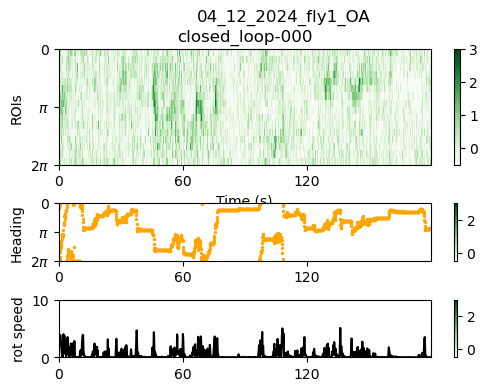

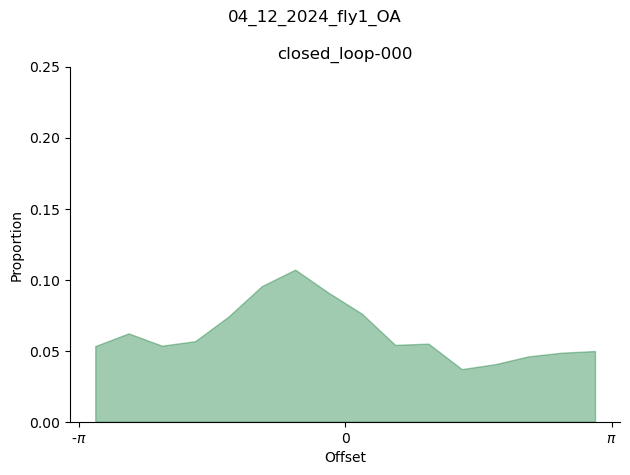

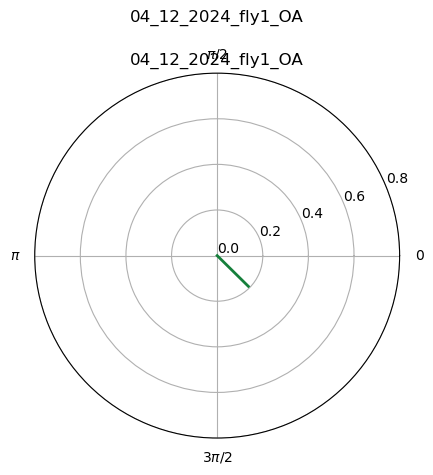

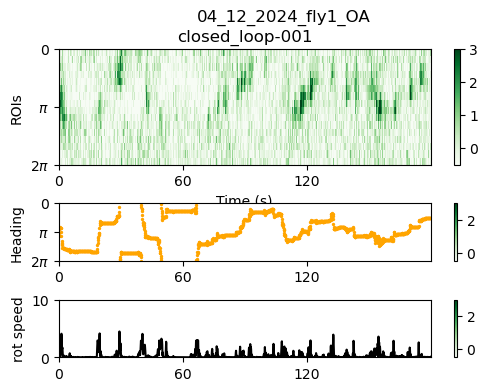

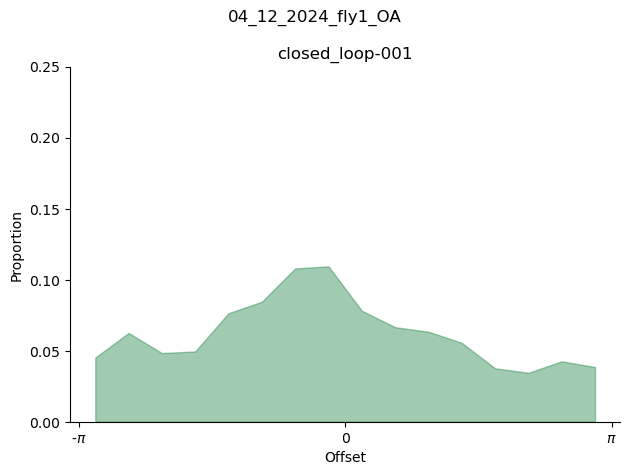

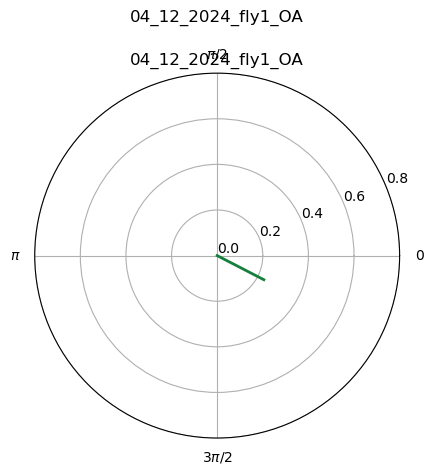

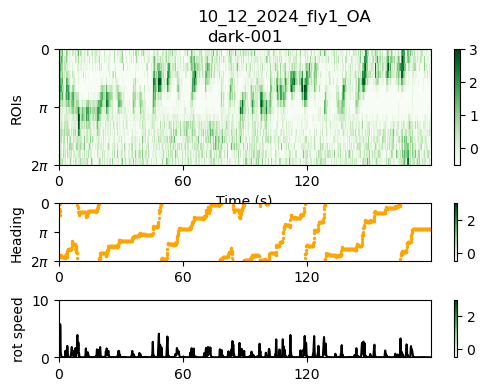

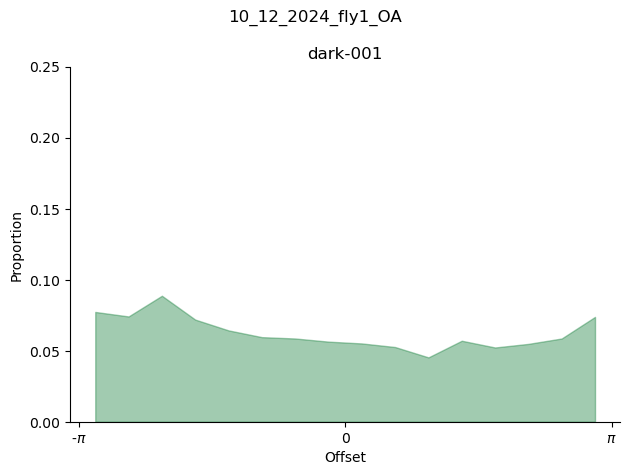

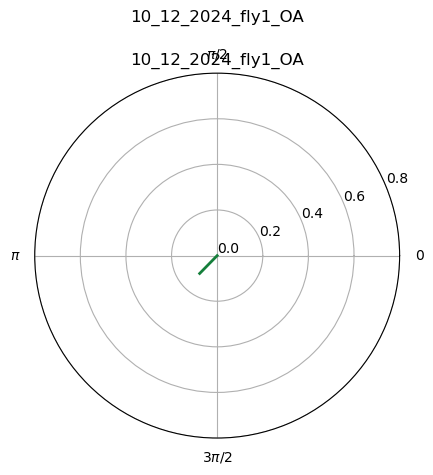

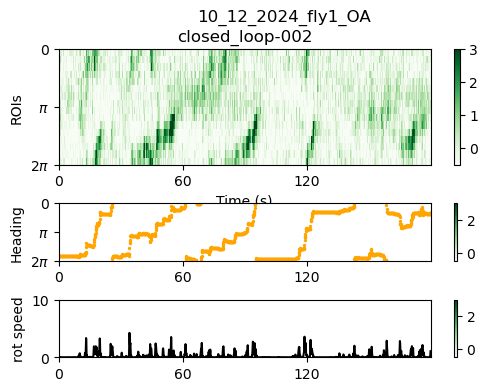

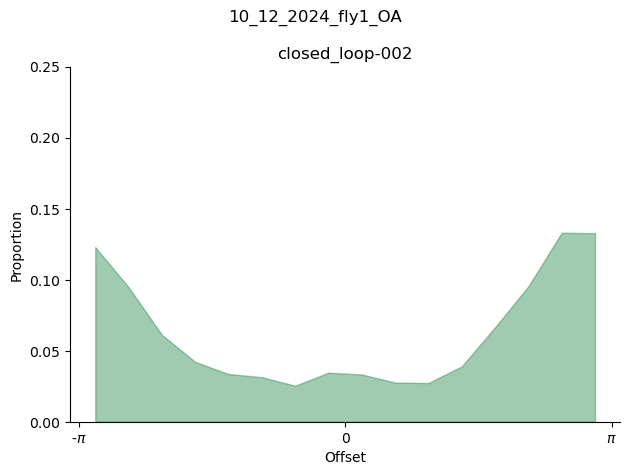

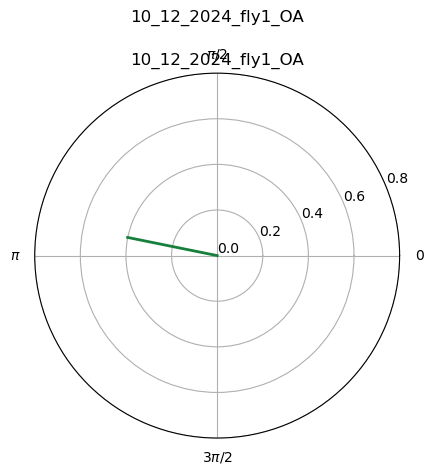

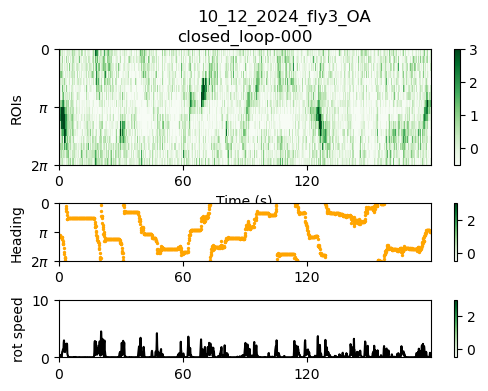

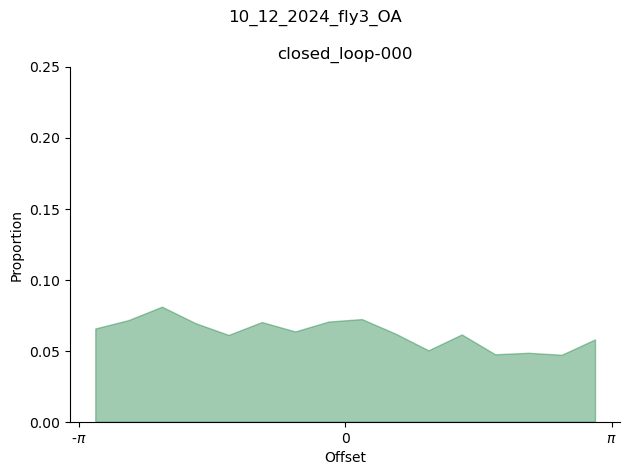

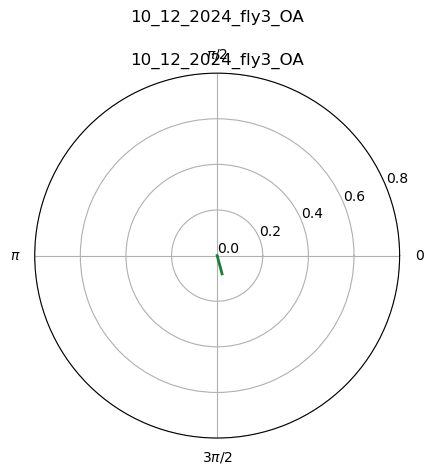

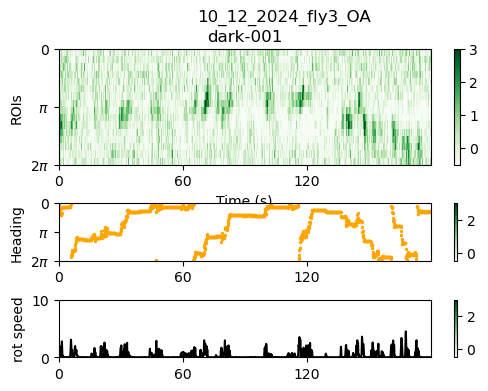

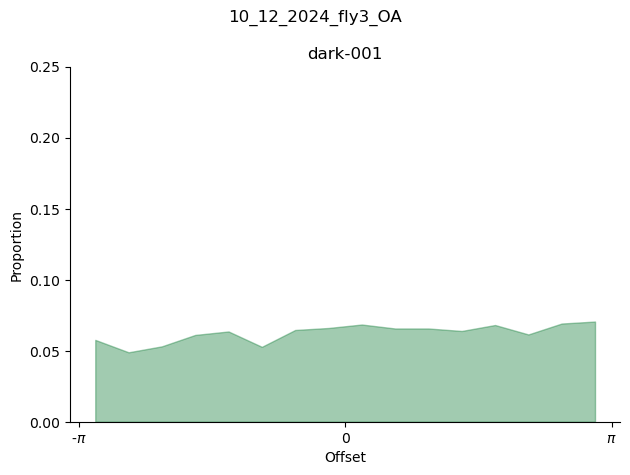

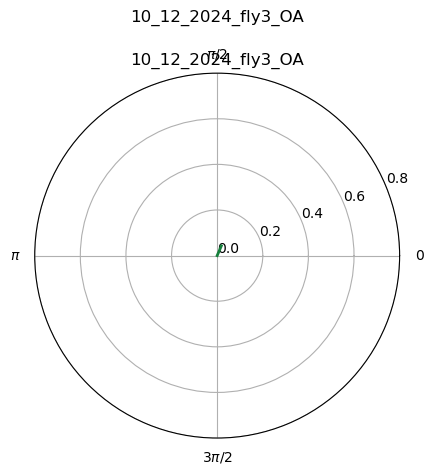

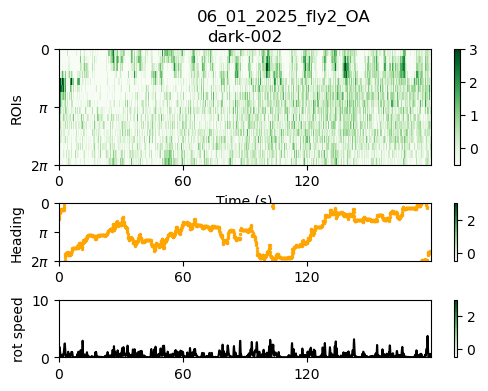

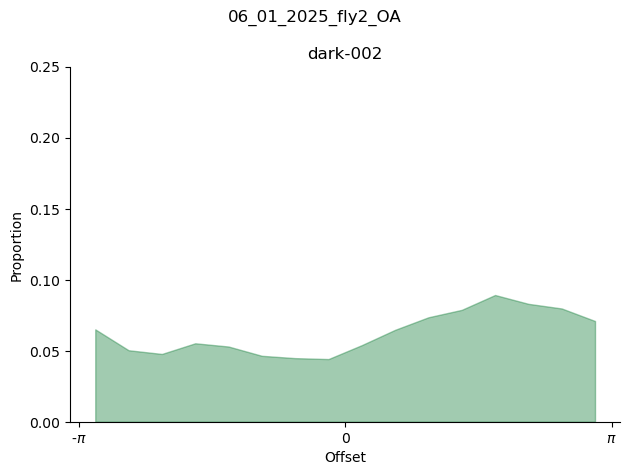

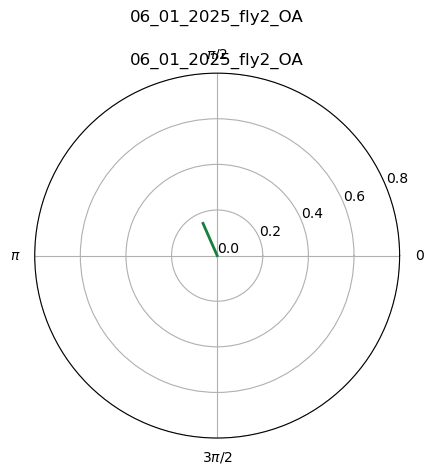

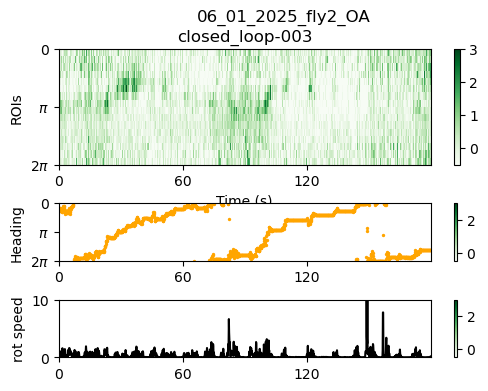

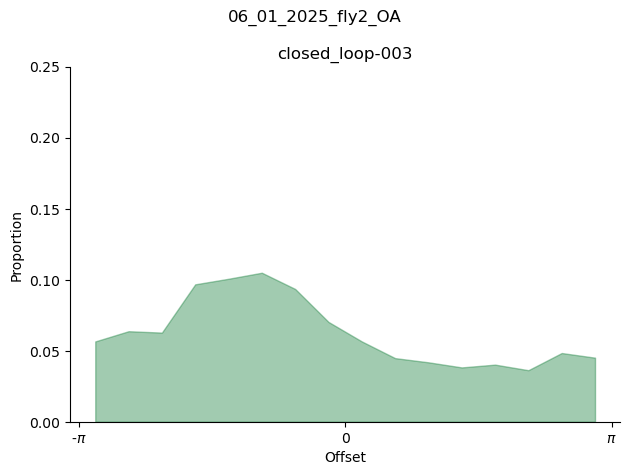

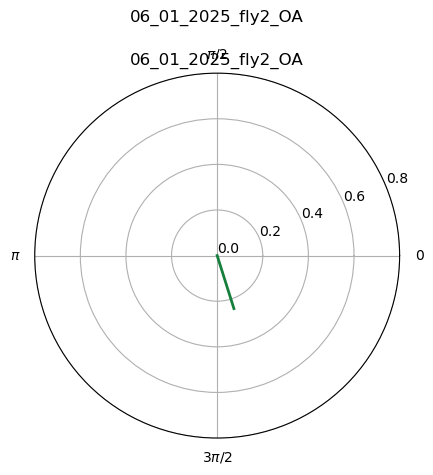

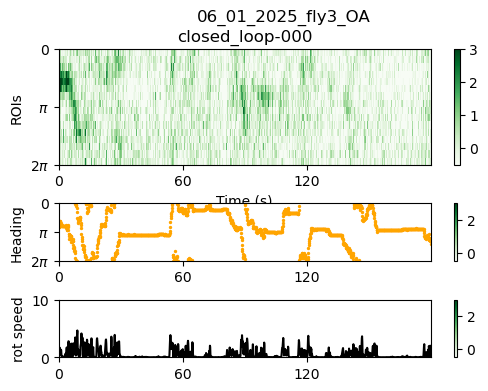

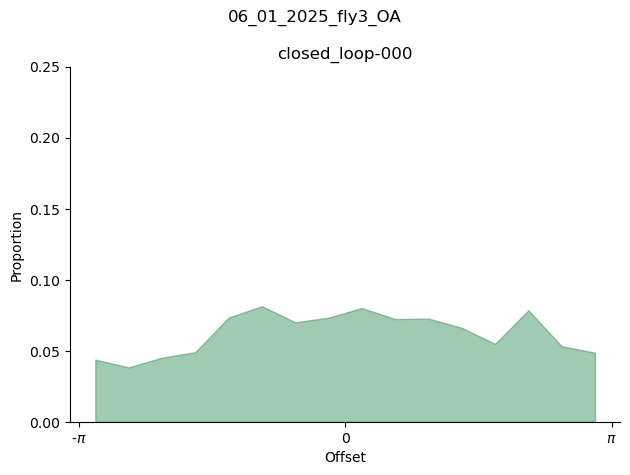

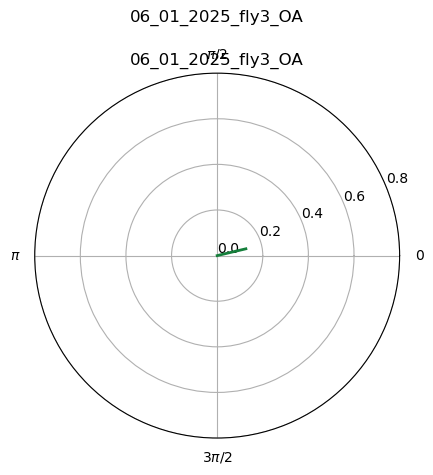

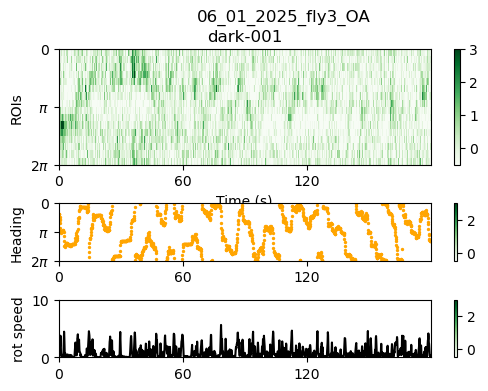

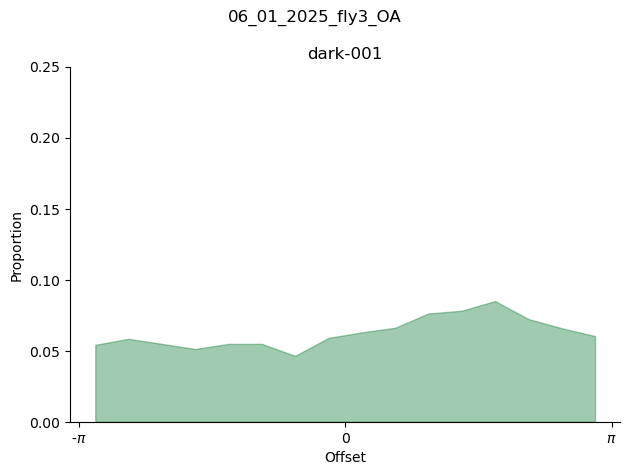

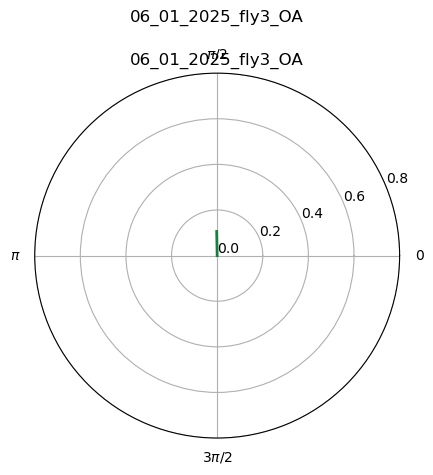

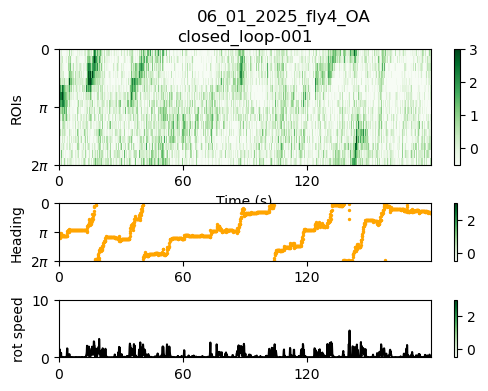

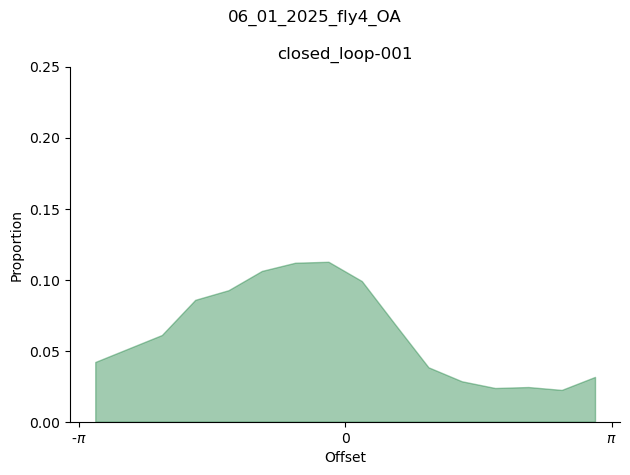

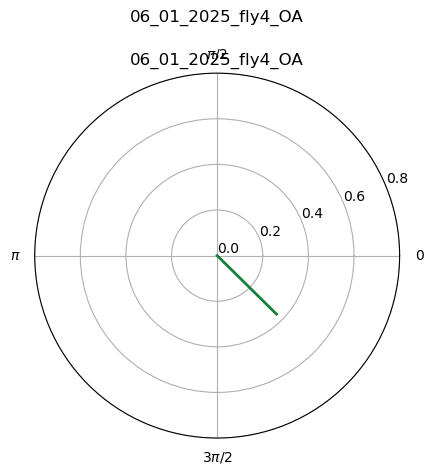

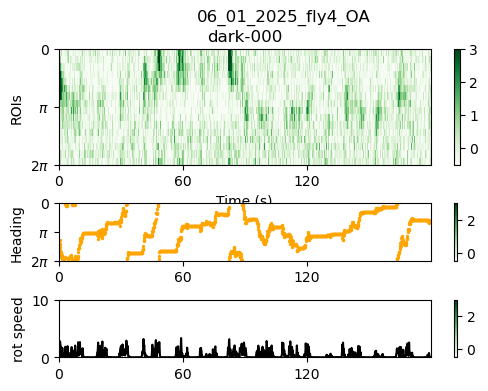

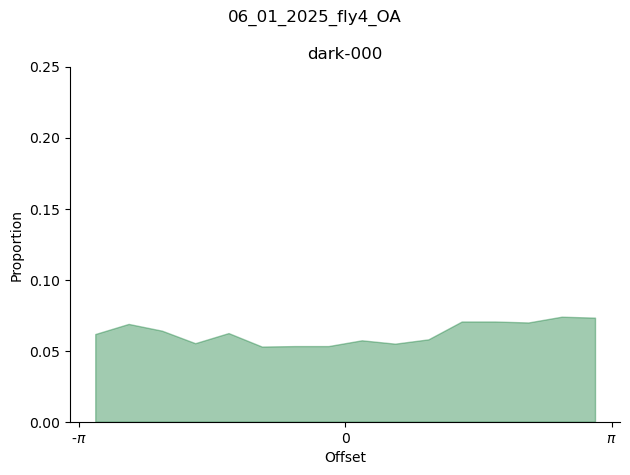

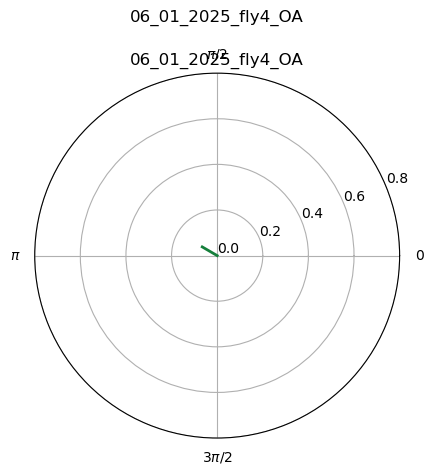

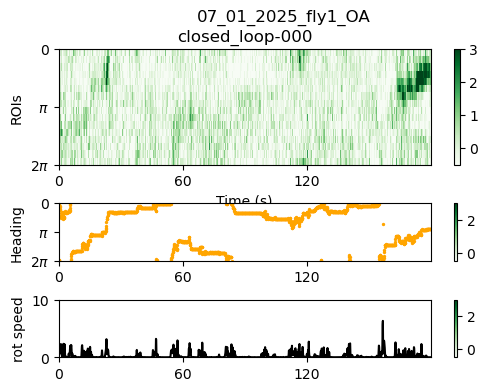

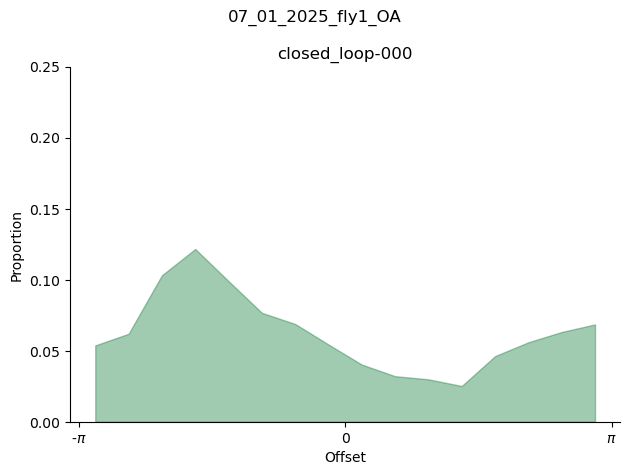

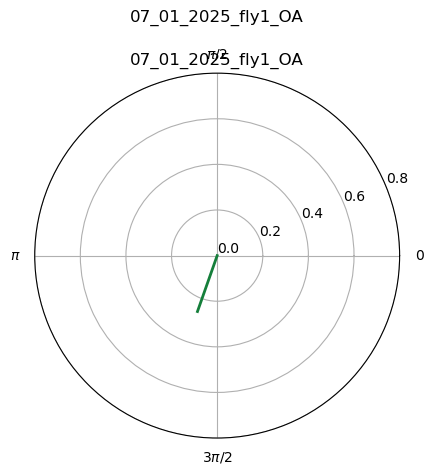

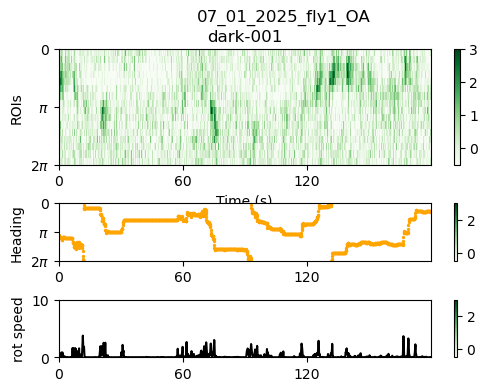

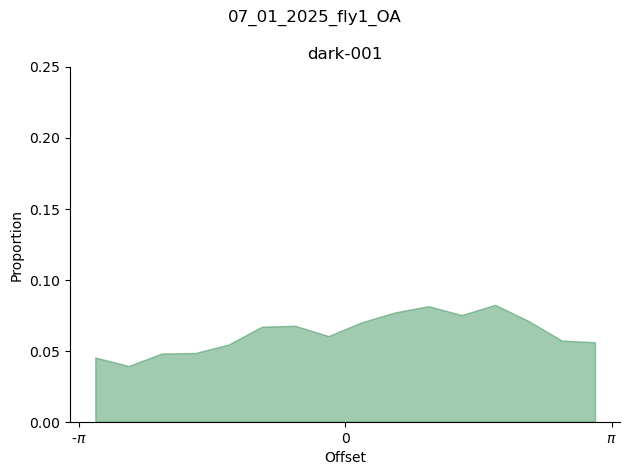

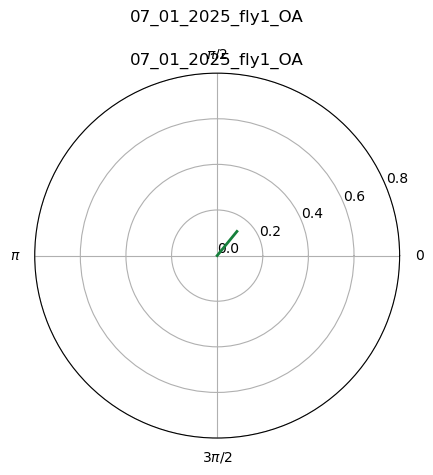

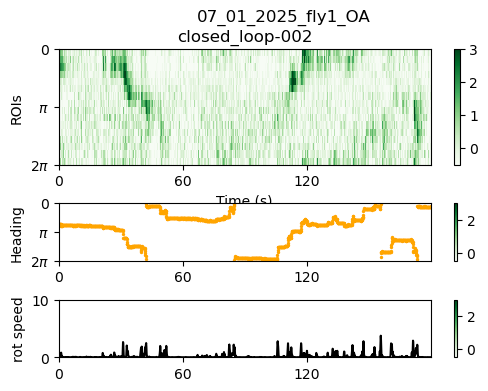

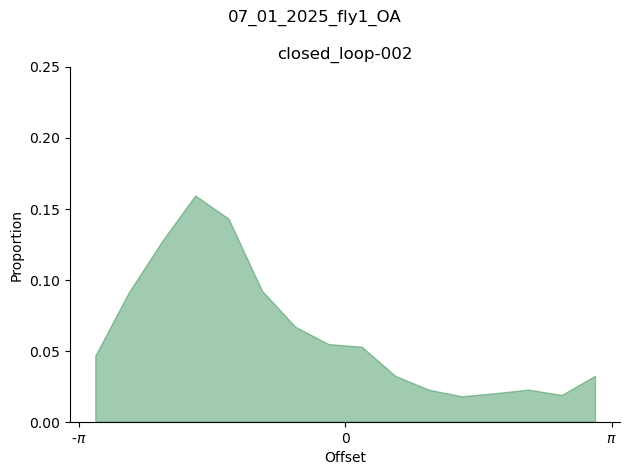

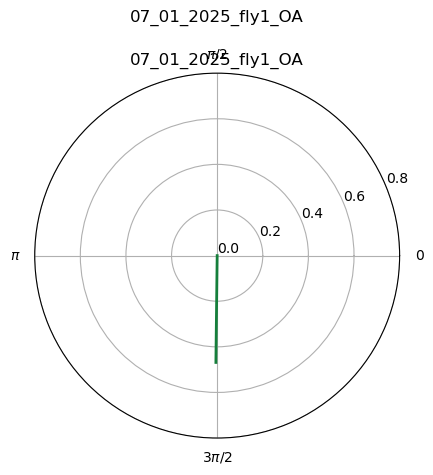

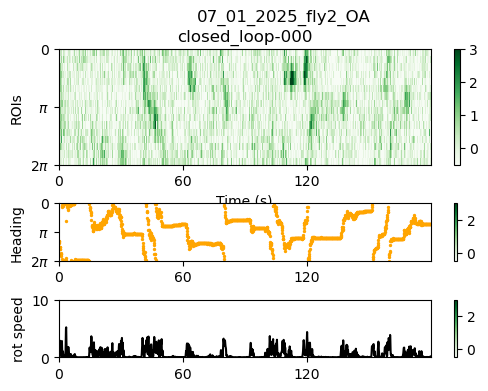

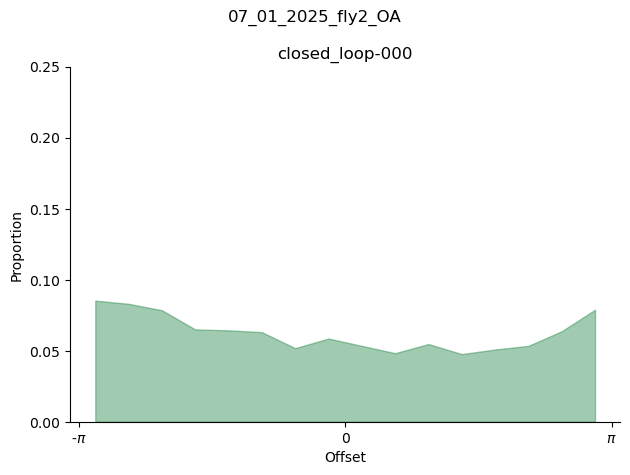

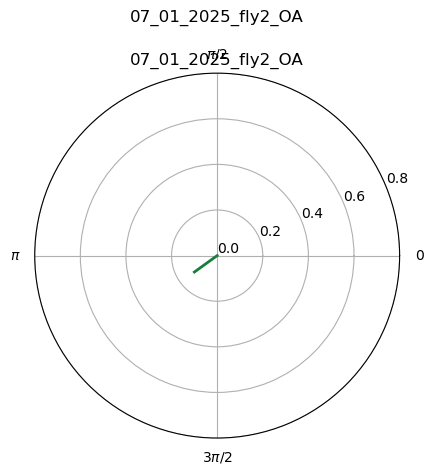

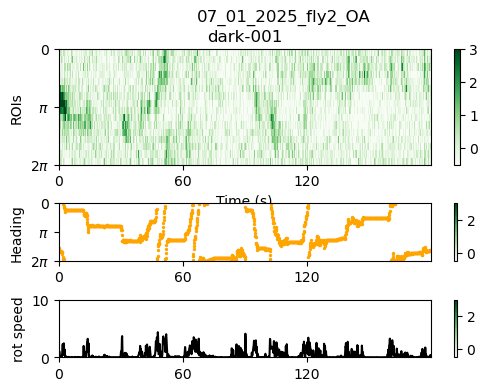

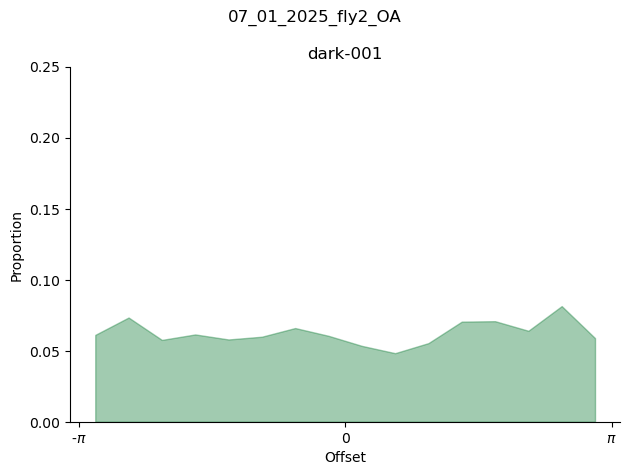

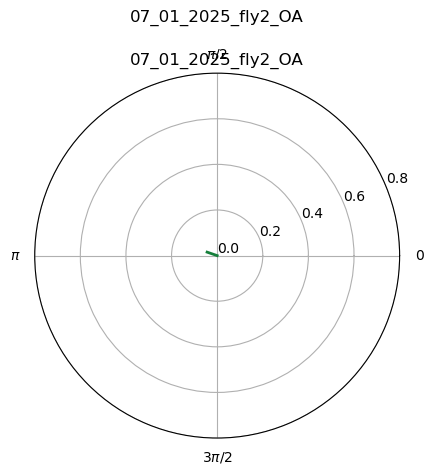

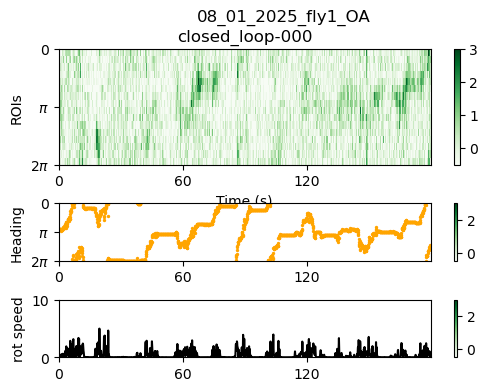

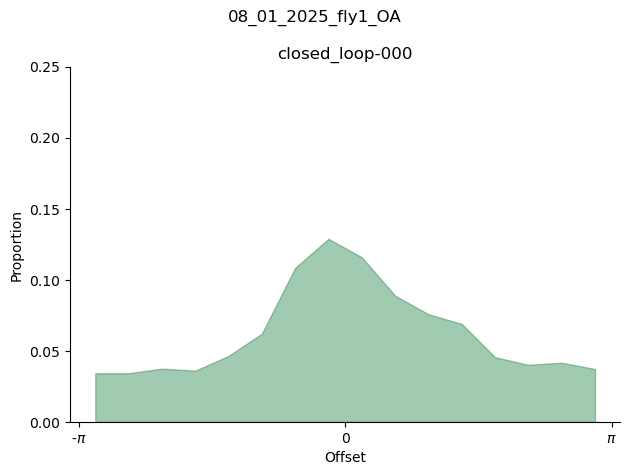

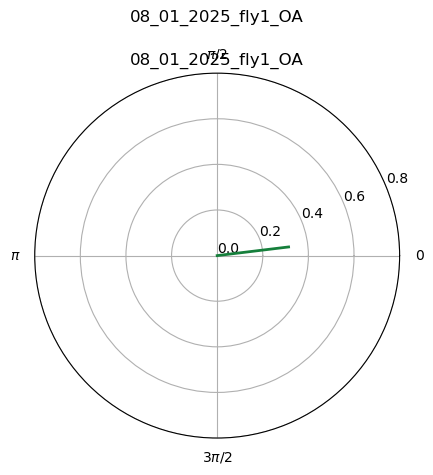

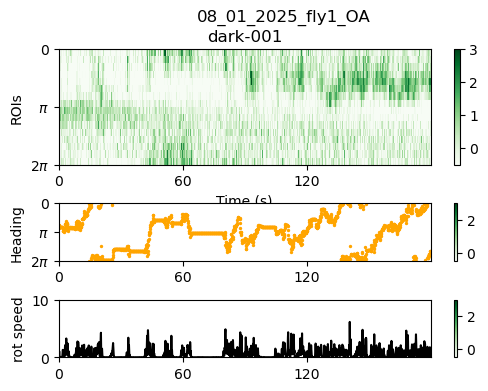

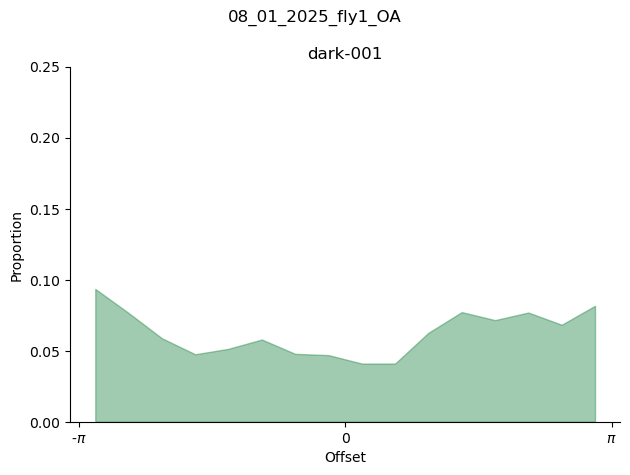

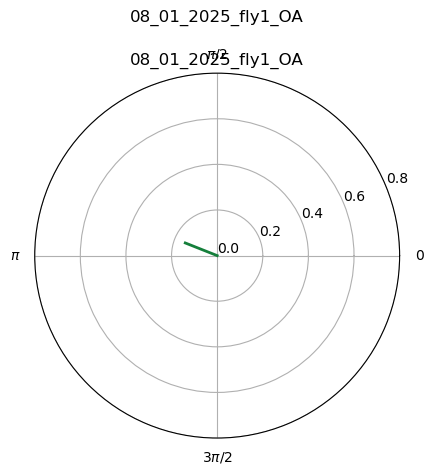

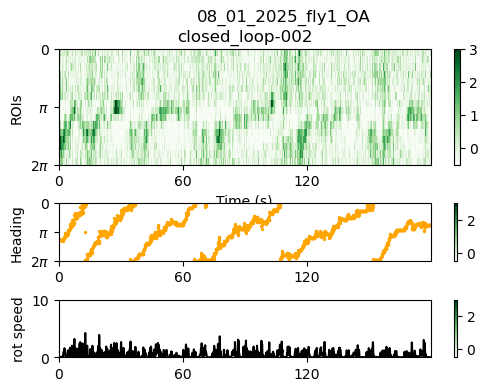

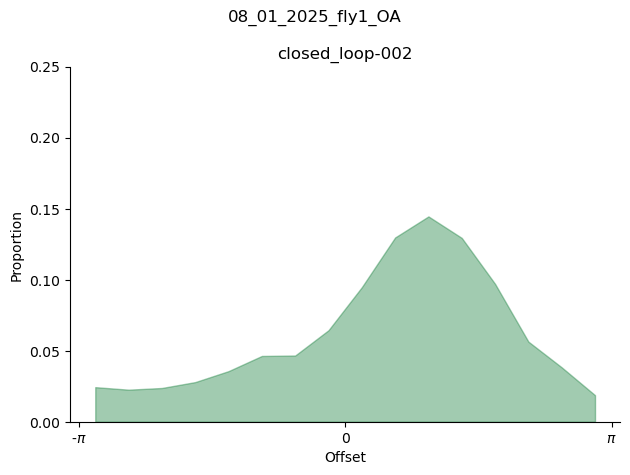

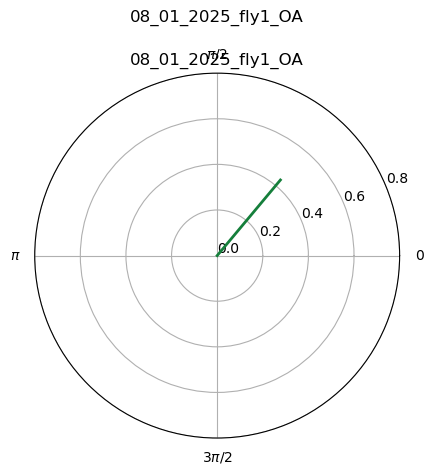

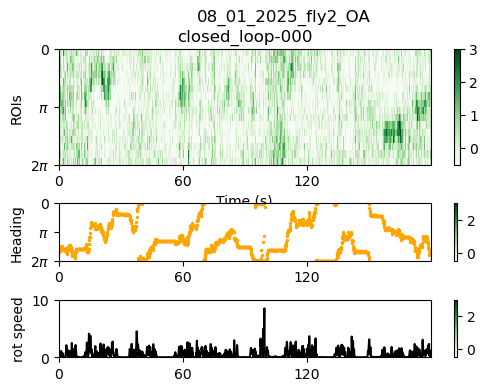

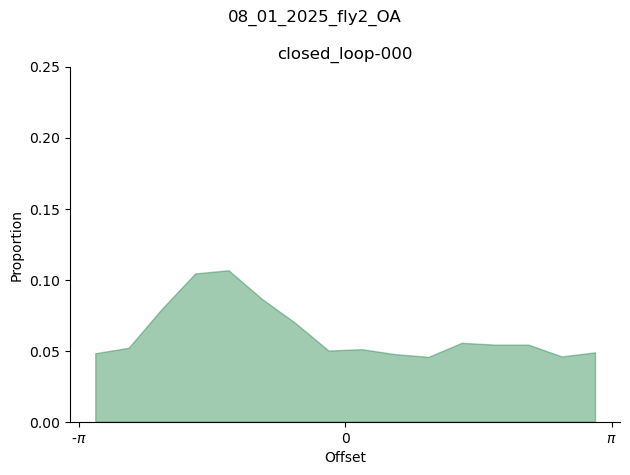

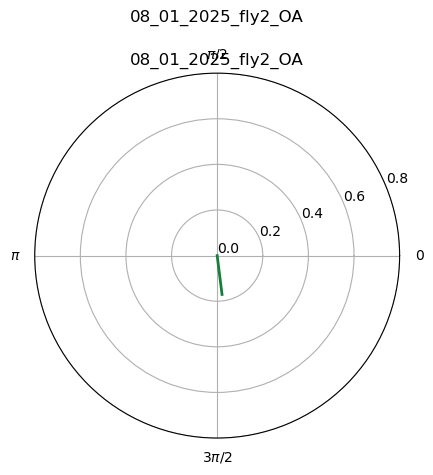

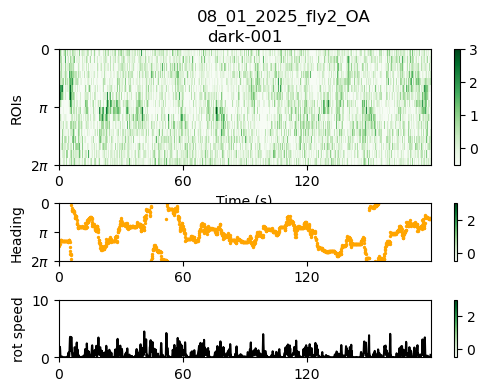

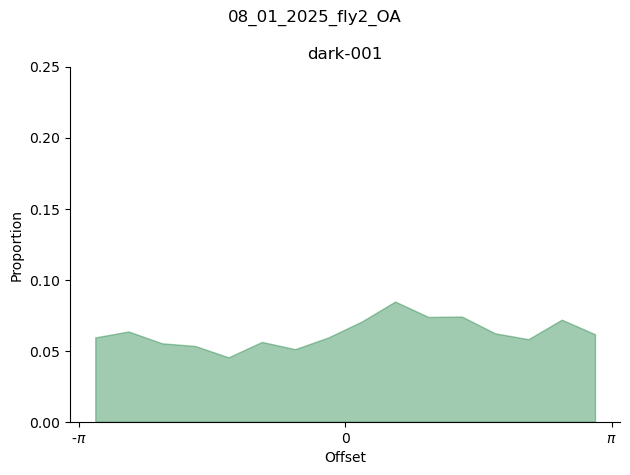

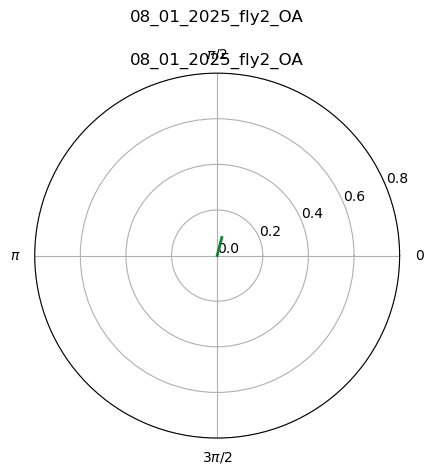

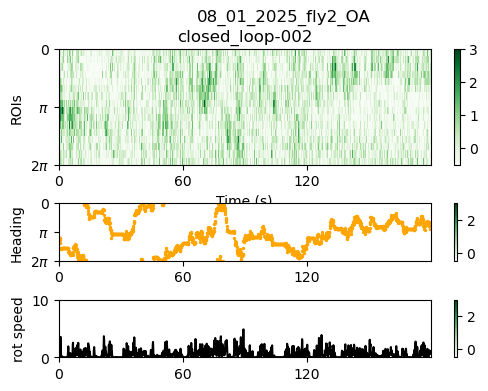

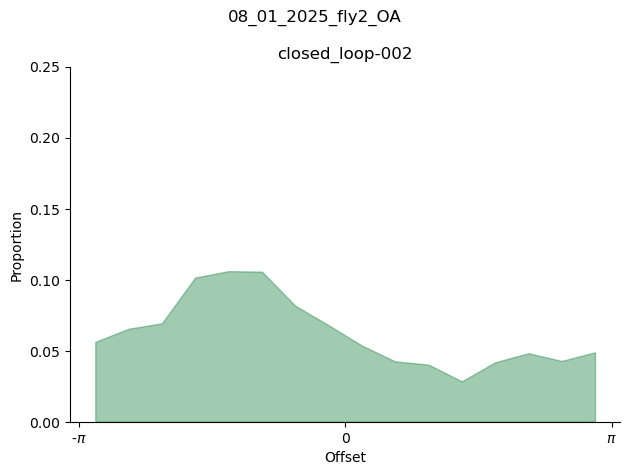

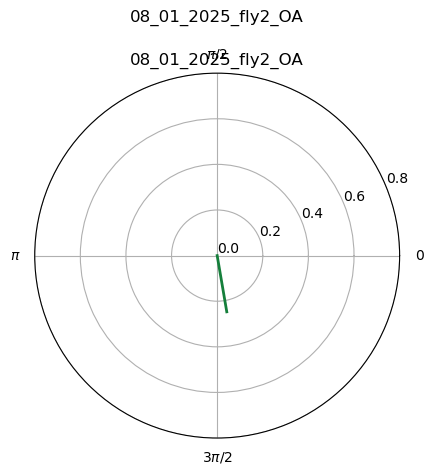

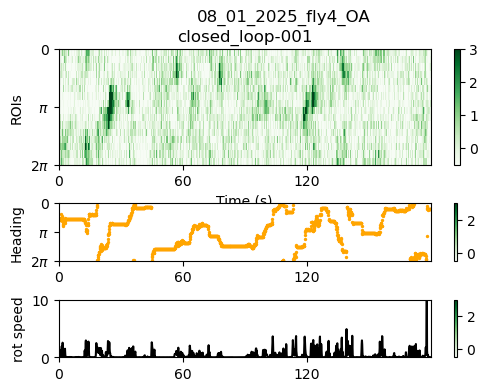

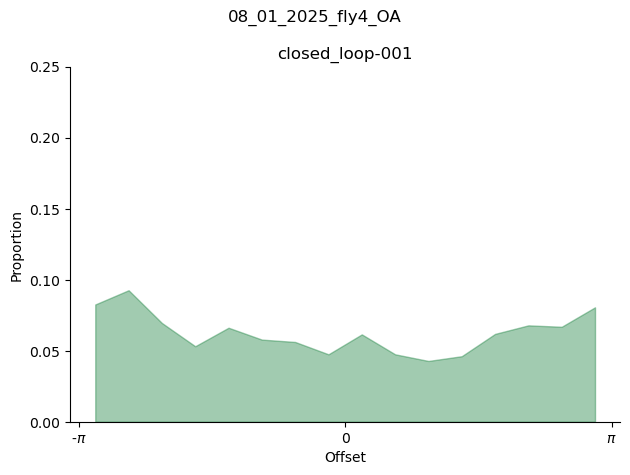

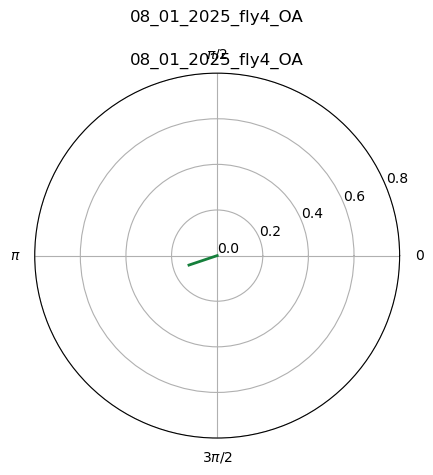

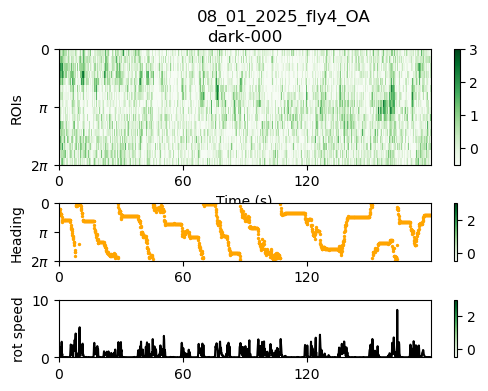

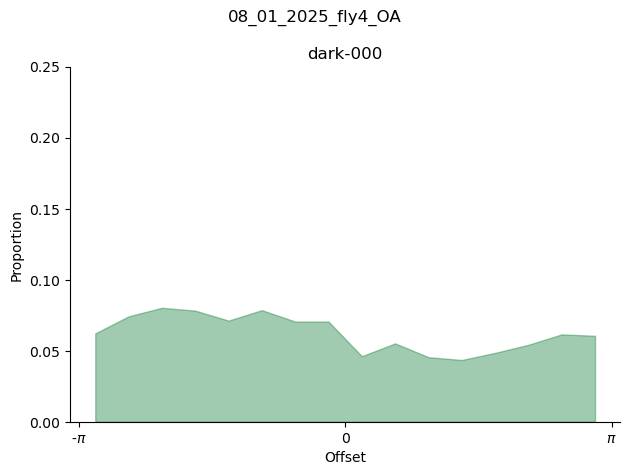

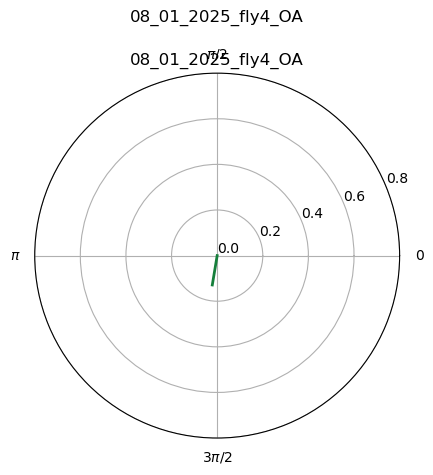

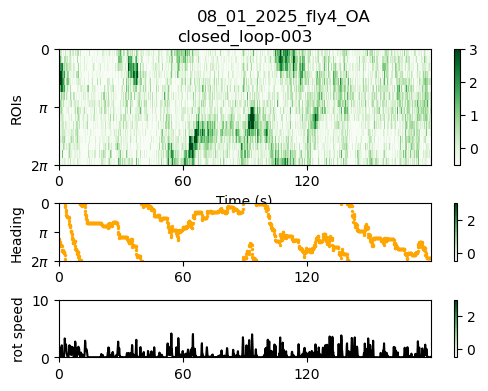

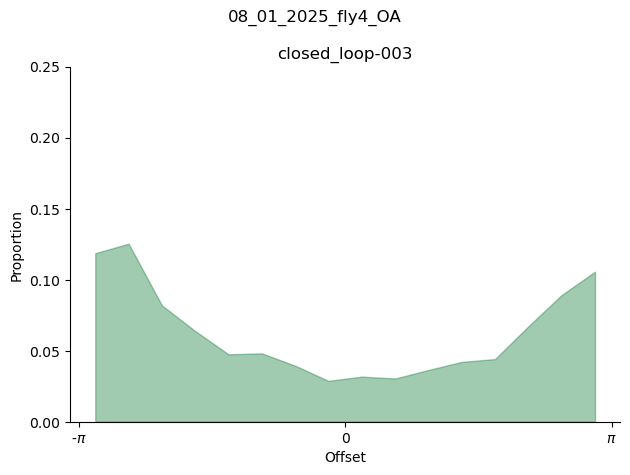

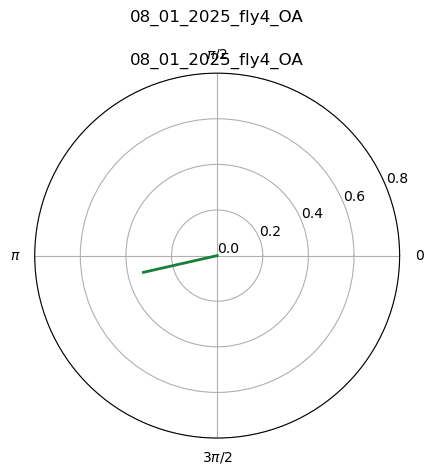

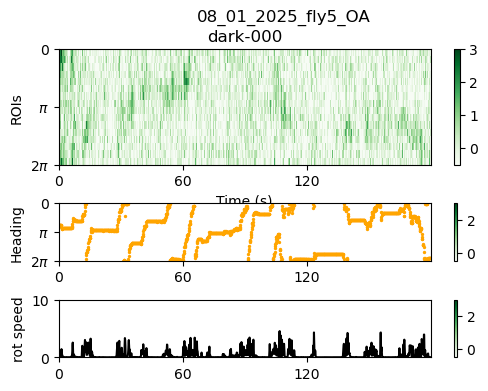

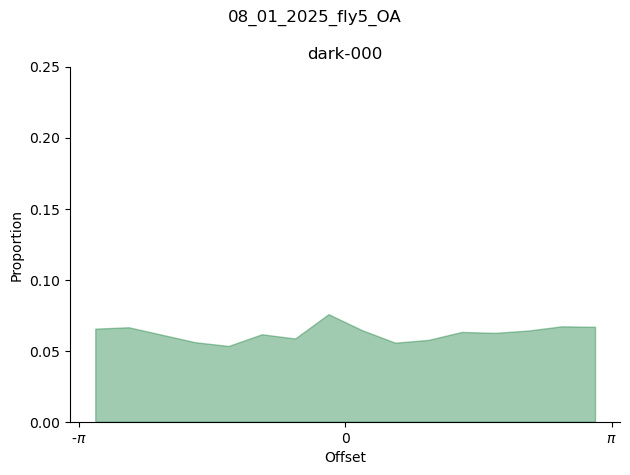

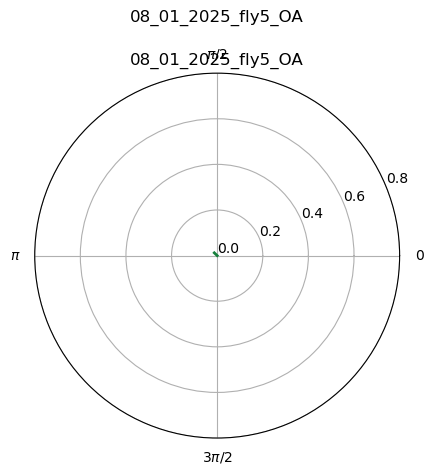

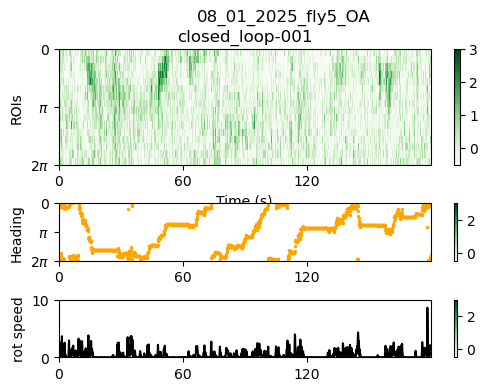

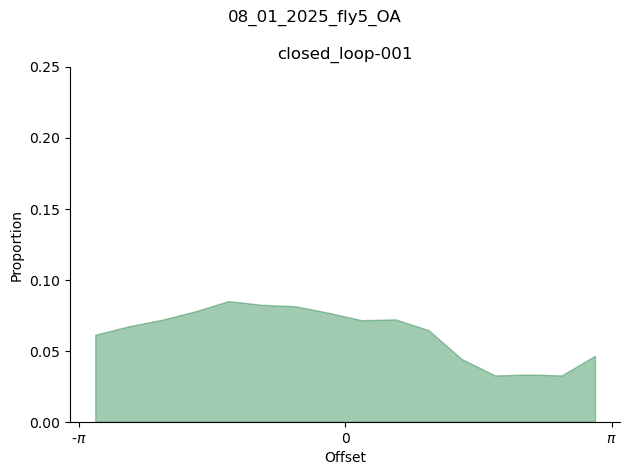

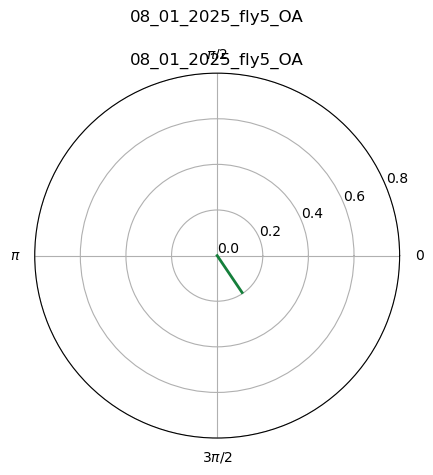

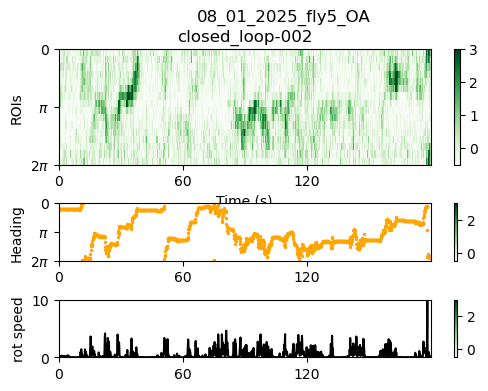

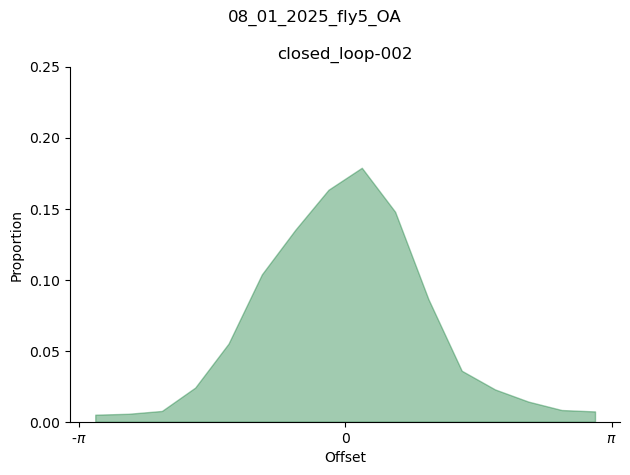

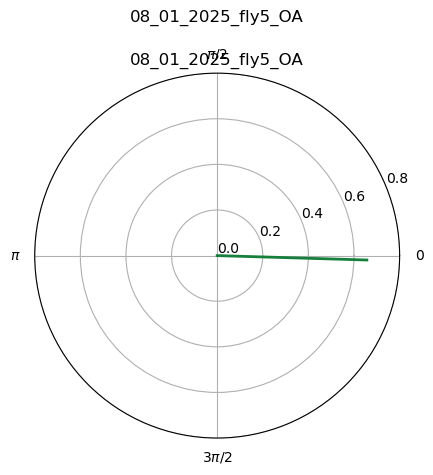

In [38]:
session_folder = graboa_sess.fig_folder / "sessions"
# plt.ioff()
for _, row in graboa_sess.sess_df.iterrows():
        
    ts_dict = {'fly': row['fly_id'],
                row['session']: nmp.session.GetTS(graboa_sess.load_row(row))
    }
    
    fig_heatmaps = nmp.grab_sensors.plot_sess_heatmaps(ts_dict, cmap='Greens', twindow=(0, 180), vmin=-.5, vmax=3)
    (fig_hist, ax_hist), (fig_polar, ax_polar) = nmp.grab_sensors.plot_sess_histograms(ts_dict, cmap='Greens')

    fly_folder = session_folder / row['fly_id'] / row['session']
    fly_folder.mkdir(exist_ok=True, parents=True)

    fig_heatmaps.savefig(fly_folder / "heatmaps.pdf", format='pdf', bbox_inches='tight')
    fig_hist.savefig(fly_folder / "offset_hist.pdf", format='pdf', bbox_inches='tight')
    fig_polar.savefig(fly_folder / "offset_polar.pdf", format='pdf', bbox_inches='tight')

    # fig_heatmaps.clf()
    # fig_hist.clf()
    # fig_polar.clf()
    

# plt.ion()

In [39]:
def align_peaks_split_halves(sess_cls, rot_speed_mask=True):
    first_half_aligned, second_half_aligned = [], []
    for _, row in sess_cls.sess_df.iterrows():
        if row['closed_loop']>0:
            ts = nmp.session.GetTS(sess_cls.load_row(row))
            
            if rot_speed_mask:
                dh_mask = np.abs(ts.dh)>.5
                dff_h_aligned = ts.dff_h_aligned[:,dh_mask]
            else:
                dff_h_aligned = ts.dff_h_aligned

            n = dff_h_aligned.shape[1]
            split = n//2
            
            
            
            first_half = dff_h_aligned[:,:split].mean(axis=1)
            second_half = dff_h_aligned[:,split:].mean(axis=1)

            shift = np.argmax(first_half)
            first_half_aligned.append(np.roll(first_half, -shift-8))
            second_half_aligned.append(np.roll(second_half, -shift-8, axis=0))

    first_half_aligned = np.stack(first_half_aligned)
    second_half_aligned = np.stack(second_half_aligned)
    return first_half_aligned, second_half_aligned

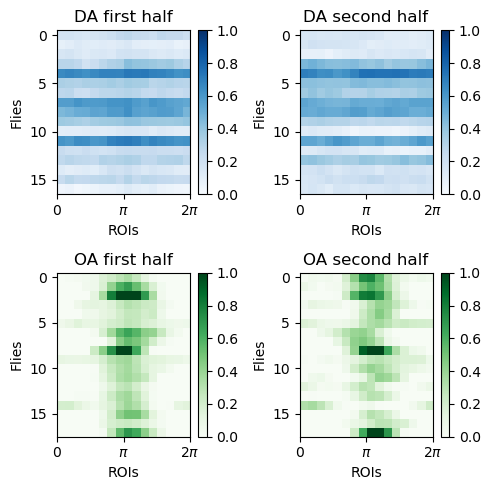

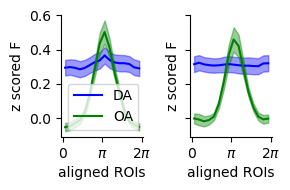

In [40]:
# align GRABOA peaks- split halves
oa_first_half, oa_second_half = align_peaks_split_halves(graboa_sess)
da_first_half, da_second_half = align_peaks_split_halves(grabda_sess)


fig, ax = plt.subplots(2,2, figsize=[5,5])
h = ax[0,0].imshow(da_first_half, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
fig.colorbar(h, ax=ax[0,0])
h = ax[0,1].imshow(da_second_half, aspect='auto', cmap='Blues', vmin=0, vmax=1, interpolation='none')
fig.colorbar(h, ax=ax[0,1])
h = ax[1,0].imshow(oa_first_half, aspect='auto', cmap='Greens', vmin=0, vmax=1, interpolation='none')
fig.colorbar(h, ax=ax[1,0])
h = ax[1,1].imshow(oa_second_half, aspect='auto', cmap='Greens', vmin=0, vmax=1, interpolation='none')
fig.colorbar(h, ax=ax[1,1])

ax[0,0].set_title('DA first half')  
ax[0,1].set_title('DA second half')
ax[1,0].set_title('OA first half')
ax[1,1].set_title('OA second half')
for a in ax.flatten():
    a.set_xlabel('ROIs')
    a.set_ylabel('Flies')
    a.set_xticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
    # a.set_yticks([])    

fig.tight_layout()
fig.savefig(common_fig_folder / 'heading_aligned_heatmaps.pdf', format='pdf', bbox_inches='tight')

fig, ax = plt.subplots(1,2, figsize=[3,2], sharey=True, sharex=True)

mu, sem = da_first_half.mean(axis=0), sp.stats.sem(da_first_half, axis=0, nan_policy='omit')
ax[0].plot(mu, color='blue', label='DA')
ax[0].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='blue', alpha=.4)

mu, sem = da_second_half.mean(axis=0), sp.stats.sem(da_second_half, axis=0, nan_policy='omit')
ax[1].plot(mu, color='blue')
ax[1].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='blue', alpha=.4)

mu, sem = oa_first_half.mean(axis=0), sp.stats.sem(oa_first_half, axis=0, nan_policy='omit')
ax[0].plot(mu, color='green', label='OA')
ax[0].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='green', alpha=.4)

ax[0].legend()

mu, sem = oa_second_half.mean(axis=0), sp.stats.sem(oa_second_half, axis=0, nan_policy='omit')
ax[1].plot(mu, color='green')
ax[1].fill_between(np.arange(mu.shape[0]), mu-sem, mu+sem, color='green', alpha=.4)

# ax[0].set_title('First half (define sort)')
# ax[1].set_title('Second half (apply sort)')
# fig.suptitle('Heading aligned response')

for a in ax:
    a.set_xlabel('aligned ROIs')
    a.set_ylabel('z scored F')
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xticks([-0.5,7.5,15.5], labels=[r'0', r'$\pi$', r'$2\pi$'])
# fig.suptitle('Heading aligned response')

fig.tight_layout()
fig.savefig(common_fig_folder / 'heading_aligned_average.pdf', format='pdf', bbox_inches='tight')

In [41]:
oa_first_half.shape

(18, 16)

In [42]:
da_first_half.shape

(17, 16)